In [203]:
from scalers.custom_scalers import CustomStandardScaler, CustomMinMaxScaler
from models.fair_models_v1 import FairClassifierV1
from models.fair_models_v2 import FairClassifierV2
from models.fair_models_v3 import FairClassifierV3
from models.fair_models_v4 import FairClassifierV4
from models.fair_models_v5 import FairClassifierV5
from models.fair_models_v6 import FairClassifierV6
from models.fair_models_v7 import FairClassifierV7
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score
from fairlearn.metrics import demographic_parity_difference, true_positive_rate_difference, MetricFrame, false_positive_rate_difference
import random

# Magistrska Projekt - Demonstracija

## Priprava podatkov

Za demonstracijo bomo uporabljali javno dostopni nabor podatkov o neplačevanju s kreditnimi karticami na Tajvanu, zbranih leta 2005. Ta nabor podatkov predstavlja binarne rezultate neplačila s kreditnimi karticami za 30.000 prosilcev z informacijami, ki se nanašajo na prosilčevo zgodovino plačil in izpiske računov v šestmesečnem obdobju od aprila 2005 do septembra 2005, ter demografskimi podatki, kot so spol, starost, zakonski stan in stopnja izobrazbe prosilca. 

Morebitno neplačilo lahko pomeni, da prosilec morda ni dober kandidat za osebno posojilo, zato bo to značilnica, ki jo bomo napovedovali v primeru klasifikacije.

V primeru regresije pa bomo, da lahko primerno demonstriramo delovanje naših regresorjev, nekoliko prilagodili problem oz. informacijo o neplačilu (čeprav mogoče ne bo izgledalo najbolj smiselno).

Viri: [Dataset](https://archive.ics.uci.edu/dataset/350/default+of+credit+card+clients), [primer uporabe](https://fairlearn.org/main/auto_examples/plot_credit_loan_decisions.html#sphx-glr-auto-examples-plot-credit-loan-decisions-py)


Informacije o naboru podatkov:

| Značičnica                                   | Opis                                  |
|-------------------------------------------|----------------------------------------------|
| sex, education, marriage, age             | Demografske značilnice                        |
| pay_0, pay_2, pay_3, pay_4, pay_5, pay_6  | Status plačila (ordinalna)                   |
| bill_amt1, bill_amt2, bill_amt3, bill_amt4, bill_amt5, bill_amt6 | Znesek izpiska računa (tajvanski dolarji)     |
| pay_amt1, pay_amt2, pay_amt3, pay_amt4, pay_amt5, pay_amt6      | Znesek iz prejšnjega poročila (tajvanski dolarji)  |
| default payment next month                | Informacija o neplačilu (1 = YES, 0 = NO)       |


In [12]:
data_url = "http://archive.ics.uci.edu/ml/machine-learning-databases/00350/default%20of%20credit%20card%20clients.xls"
dataset = (
    pd.read_excel(io=data_url, header=1)
    .drop(columns=["ID"])
    .rename(columns={"PAY_0": "PAY_1", "default payment next month": "default"})
)
dataset.head()

,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_1,PAY_2,PAY_3,PAY_4,PAY_5,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default
0,20000,2,2,1,24,2,2,-1,-1,-2,...,0,0,0,0,689,0,0,0,0,1
1,120000,2,2,2,26,-1,2,0,0,0,...,3272,3455,3261,0,1000,1000,1000,0,2000,1
2,90000,2,2,2,34,0,0,0,0,0,...,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
3,50000,2,2,1,37,0,0,0,0,0,...,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
4,50000,1,2,1,57,-1,0,-1,0,0,...,20940,19146,19131,2000,36681,10000,9000,689,679,0


Preverimo, če imamo med podatki slučajno kakšne manjkajoče vrednosti.

In [13]:
for c in dataset.columns:
    print(f'col {c} number of empty rows: {dataset[c].isna().sum()}')

col LIMIT_BAL number of empty rows: 0
col SEX number of empty rows: 0
col EDUCATION number of empty rows: 0
col MARRIAGE number of empty rows: 0
col AGE number of empty rows: 0
col PAY_1 number of empty rows: 0
col PAY_2 number of empty rows: 0
col PAY_3 number of empty rows: 0
col PAY_4 number of empty rows: 0
col PAY_5 number of empty rows: 0
col PAY_6 number of empty rows: 0
col BILL_AMT1 number of empty rows: 0
col BILL_AMT2 number of empty rows: 0
col BILL_AMT3 number of empty rows: 0
col BILL_AMT4 number of empty rows: 0
col BILL_AMT5 number of empty rows: 0
col BILL_AMT6 number of empty rows: 0
col PAY_AMT1 number of empty rows: 0
col PAY_AMT2 number of empty rows: 0
col PAY_AMT3 number of empty rows: 0
col PAY_AMT4 number of empty rows: 0
col PAY_AMT5 number of empty rows: 0
col PAY_AMT6 number of empty rows: 0
col default number of empty rows: 0


Določimo naše značilnice (X), senzitivne značilnice (A) in ciljne značilnico (Y), ki jo bomo napovedovali.

In [14]:
categorical_features = ["SEX", "EDUCATION", "MARRIAGE"]
sensitive_features = ['SEX', 'EDUCATION', 'MARRIAGE', 'AGE']

for col_name in categorical_features:
    dataset[col_name] = dataset[col_name].astype("category")

Y, A = dataset["default"], dataset[sensitive_features]
X = dataset.drop(columns=sensitive_features+['default'])

In [15]:
X.head()

,LIMIT_BAL,PAY_1,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6
0,20000,2,2,-1,-1,-2,-2,3913,3102,689,0,0,0,0,689,0,0,0,0
1,120000,-1,2,0,0,0,2,2682,1725,2682,3272,3455,3261,0,1000,1000,1000,0,2000
2,90000,0,0,0,0,0,0,29239,14027,13559,14331,14948,15549,1518,1500,1000,1000,1000,5000
3,50000,0,0,0,0,0,0,46990,48233,49291,28314,28959,29547,2000,2019,1200,1100,1069,1000
4,50000,-1,0,-1,0,0,0,8617,5670,35835,20940,19146,19131,2000,36681,10000,9000,689,679


In [16]:
A.head()

,SEX,EDUCATION,MARRIAGE,AGE
0,2,2,1,24
1,2,2,2,26
2,2,2,2,34
3,2,2,1,37
4,1,2,1,57


In [17]:
Y.head()

0    1
1    1
2    0
3    0
4    0
Name: default, dtype: int64

Mapiramo vrednosti senzitivnih spremenljivk v označbe za boljšo preglednost 

In [18]:
mapping_sex = {1: 'male', 2: 'female'}
mapping_education = {0: 'edu0', 1: 'edu1', 2: 'edu2', 3: 'edu3', 4: 'edu4', 5: 'edu5', 6: 'edu6'}
mapping_marriage = {0: 'mar0', 1: 'mar1', 2: 'mar2', 3: 'mar3'}

In [19]:
A_mapped = A.copy()
A_mapped['SEX'] = A_mapped['SEX'].map(mapping_sex)
A_mapped['EDUCATION'] = A_mapped['EDUCATION'].map(mapping_education)
A_mapped['MARRIAGE'] = A_mapped['MARRIAGE'].map(mapping_marriage)
A_mapped.head()

,SEX,EDUCATION,MARRIAGE,AGE
0,female,edu2,mar1,24
1,female,edu2,mar2,26
2,female,edu2,mar2,34
3,female,edu2,mar1,37
4,male,edu2,mar1,57


Iz obstoječih kategoričnih spremenljivk lahko ustvarimo nekatere nove, npr. kombinacijo spola in izobrazbe ali kombinacijo spola in zakonskega stana.

In [20]:
A_mapped['SEX_EDUCATION'] = A_mapped['SEX'].astype(str) + '_' + A_mapped['EDUCATION'].astype(str)
A_mapped['SEX_MARRIAGE'] = A_mapped['SEX'].astype(str) + '_' + A_mapped['MARRIAGE'].astype(str)
A_mapped.head()

,SEX,EDUCATION,MARRIAGE,AGE,SEX_EDUCATION,SEX_MARRIAGE
0,female,edu2,mar1,24,female_edu2,female_mar1
1,female,edu2,mar2,26,female_edu2,female_mar2
2,female,edu2,mar2,34,female_edu2,female_mar2
3,female,edu2,mar1,37,female_edu2,female_mar1
4,male,edu2,mar1,57,male_edu2,male_mar1


Preglejmo porazdeljenost ciljne značilnice naše instance (informacija, če je naš kandidat primeren za posojilo). Ker je v naboru podatkov ta značilnica označena kot informacija o neplačilu, bomo jo za naš problem zaradi preglednosti nekoliko prilagodili (zamenjali 0 in 1).

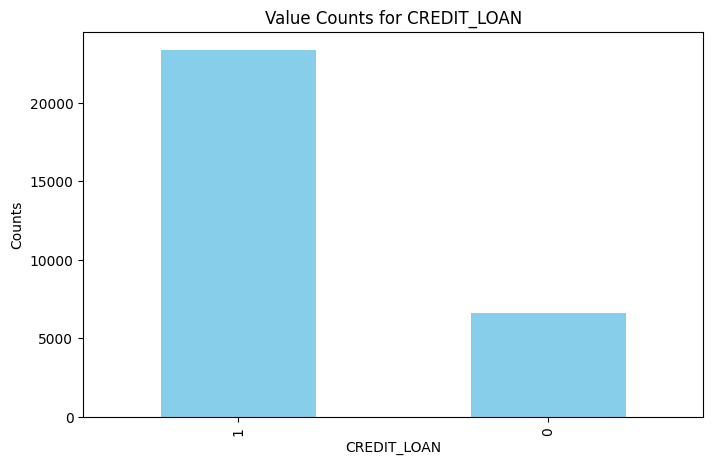

In [21]:
mapping_loan = {0: 1, 1: 0}
Y = Y.map(mapping_loan)
Y.value_counts().plot(kind='bar', color='skyblue', figsize=(8, 5))
plt.title('Value Counts for CREDIT_LOAN')
plt.xlabel('CREDIT_LOAN')
plt.ylabel('Counts')
plt.show;

Preglejmo še število instanc senzitivnih skupin za vsako senzitivno značilnico.

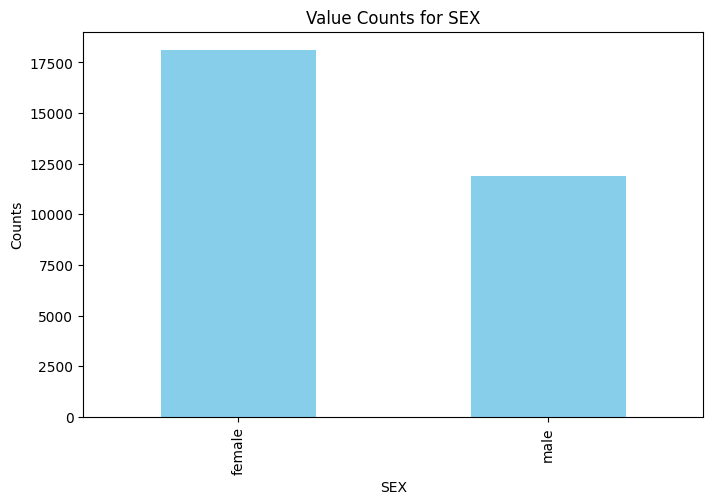

In [22]:
A_mapped['SEX'].value_counts().plot(kind='bar', color='skyblue', figsize=(8, 5))
plt.title('Value Counts for SEX')
plt.xlabel('SEX')
plt.ylabel('Counts')
plt.show;

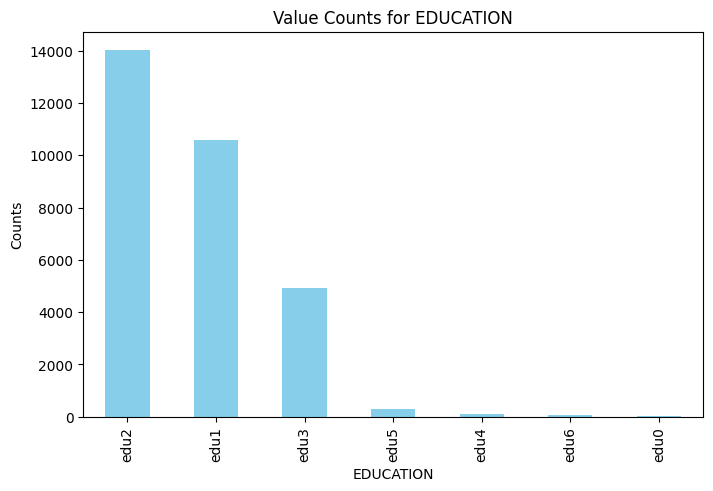

In [23]:
A_mapped['EDUCATION'].value_counts().plot(kind='bar', color='skyblue', figsize=(8, 5))
plt.title('Value Counts for EDUCATION')
plt.xlabel('EDUCATION')
plt.ylabel('Counts')
plt.show;

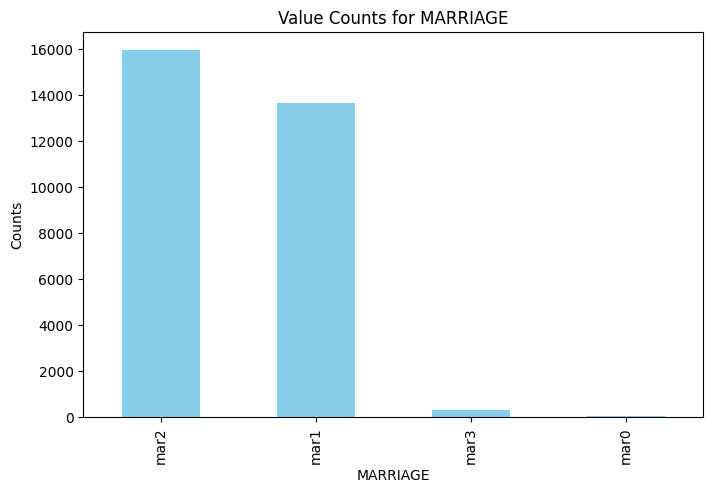

In [24]:
A_mapped['MARRIAGE'].value_counts().plot(kind='bar', color='skyblue', figsize=(8, 5))
plt.title('Value Counts for MARRIAGE')
plt.xlabel('MARRIAGE')
plt.ylabel('Counts')
plt.show;

Text(0, 0.5, 'Frequency')

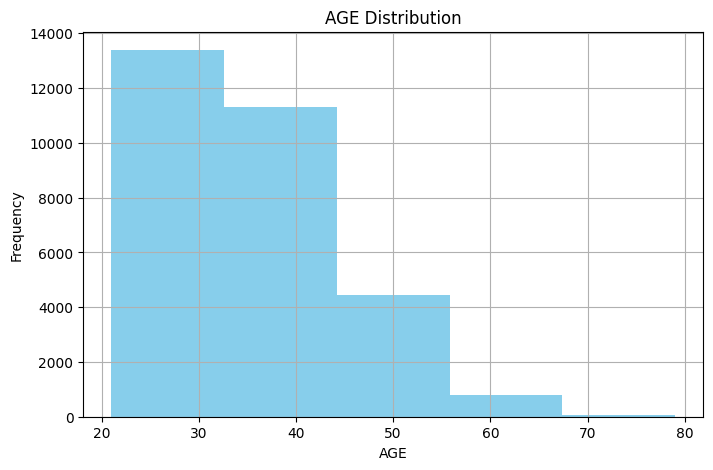

In [25]:
A_mapped['AGE'].hist(bins=5, color='skyblue', figsize=(8, 5))
plt.title('AGE Distribution')
plt.xlabel('AGE')
plt.ylabel('Frequency')

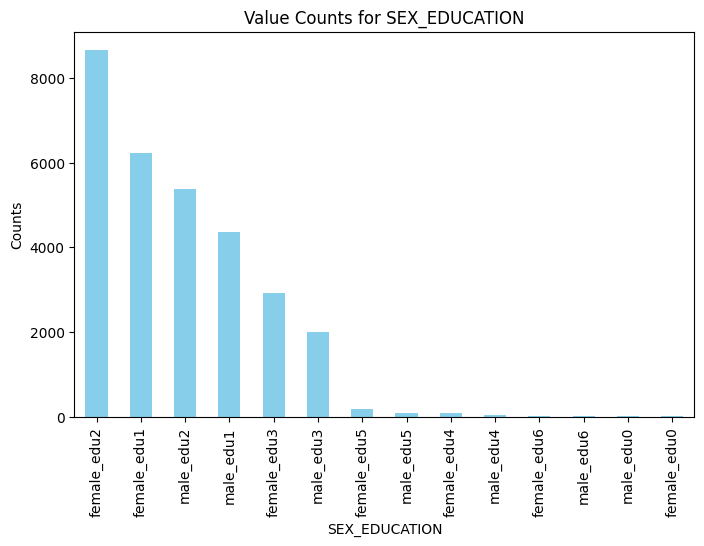

In [26]:
A_mapped['SEX_EDUCATION'].value_counts().plot(kind='bar', color='skyblue', figsize=(8, 5))
plt.title('Value Counts for SEX_EDUCATION')
plt.xlabel('SEX_EDUCATION')
plt.ylabel('Counts')
plt.show;

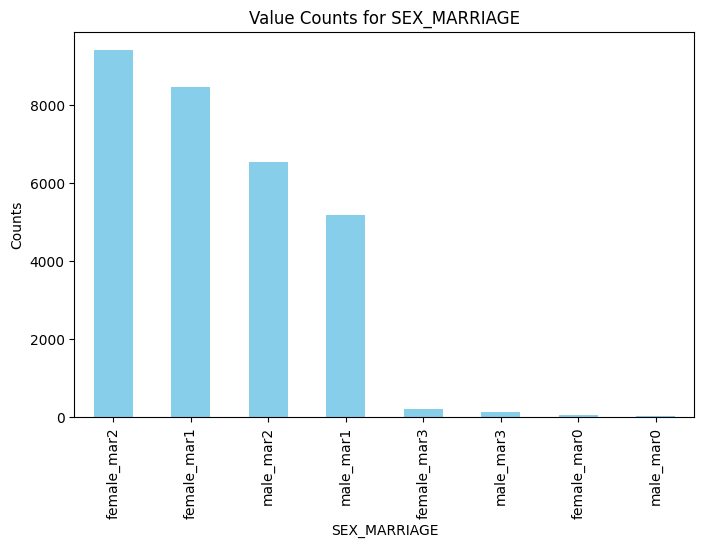

In [27]:
A_mapped['SEX_MARRIAGE'].value_counts().plot(kind='bar', color='skyblue', figsize=(8, 5))
plt.title('Value Counts for SEX_MARRIAGE')
plt.xlabel('SEX_MARRIAGE')
plt.ylabel('Counts')
plt.show;

Kot vidimo imamo za nekatere senzitivne značilnice v nekaterih senzitivnih skupinah slabšo reprezentacijo, za te senzitivne skupine bi lahko pričakovali slabše rezultate.

Npr. za izobrazbo bi lahko manj reprezentativne skupine združili skupaj, da bi za njih imeli dovolj podatkov za učenje modelov.

In [28]:
A_mapped['EDUCATION'] = A_mapped['EDUCATION'].astype(str)
A_mapped['EDUCATION'] = A_mapped['EDUCATION'].where(
    A_mapped['EDUCATION'].isin(['edu1', 'edu2', 'edu3']), 
    other='edu_other'
)
A_mapped['SEX_EDUCATION'] = A_mapped['SEX'].astype(str) + '_' + A_mapped['EDUCATION'].astype(str)
A_mapped.head()

,SEX,EDUCATION,MARRIAGE,AGE,SEX_EDUCATION,SEX_MARRIAGE
0,female,edu2,mar1,24,female_edu2,female_mar1
1,female,edu2,mar2,26,female_edu2,female_mar2
2,female,edu2,mar2,34,female_edu2,female_mar2
3,female,edu2,mar1,37,female_edu2,female_mar1
4,male,edu2,mar1,57,male_edu2,male_mar1


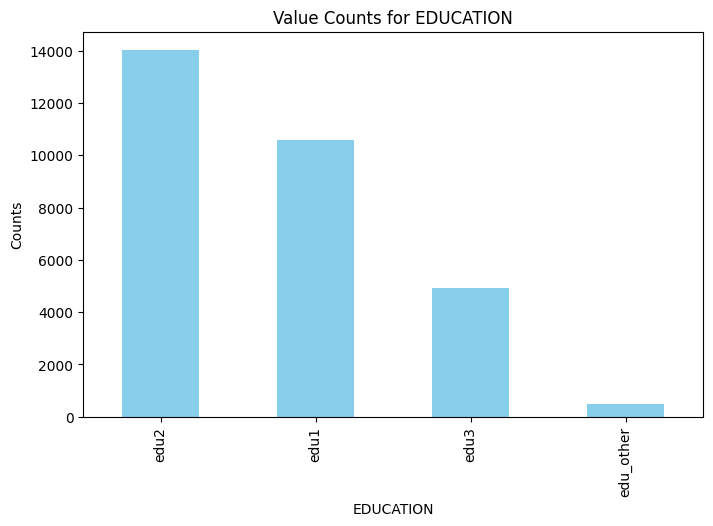

In [29]:
A_mapped['EDUCATION'].value_counts().plot(kind='bar', color='skyblue', figsize=(8, 5))
plt.title('Value Counts for EDUCATION')
plt.xlabel('EDUCATION')
plt.ylabel('Counts')
plt.show;

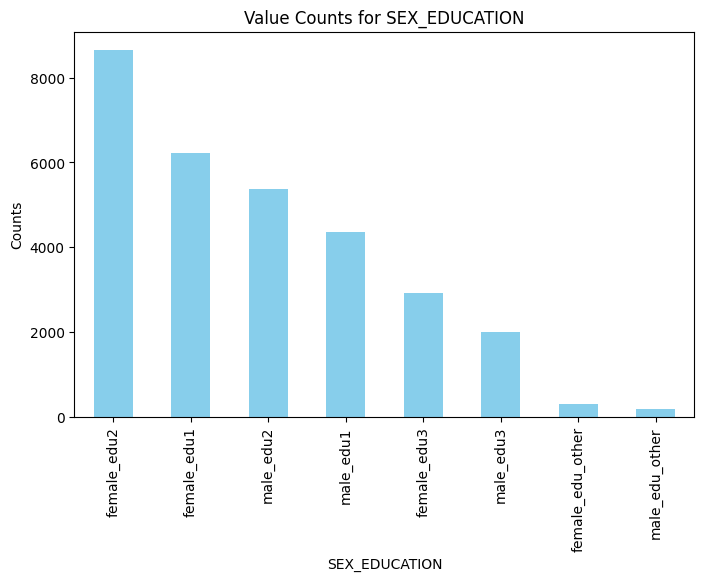

In [30]:
A_mapped['SEX_EDUCATION'].value_counts().plot(kind='bar', color='skyblue', figsize=(8, 5))
plt.title('Value Counts for SEX_EDUCATION')
plt.xlabel('SEX_EDUCATION')
plt.ylabel('Counts')
plt.show;

Delitev podatkov na učno in testno množico

In [31]:
X_train, X_test, y_train, y_test, A_train, A_test = train_test_split(
    X, Y, A_mapped, test_size=0.20, stratify=Y, random_state=123
)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape, A_train.shape, A_test.shape)

(24000, 19) (6000, 19) (24000,) (6000,) (24000, 6) (6000, 6)


## Demonstracija modelov prilagojenih za upoštevanje pravičnosti

V tem razdelku bomo demonstrirali delovanje naših scikit-learn kompatibilnih modelov prilagojenih za upoštevanje pravičnosti. Modele bomo naučili in testirali najprej za senzitivno spremenljivko 'SEX' in nato še za kombinirano senzitivno spremenljivko 'SEX_EDUCATION'. Pri tem bomo uporabljali različne metrike pravičnosti.

Napovedovali bomo ciljno spremenljko 'CREDIT_LOAN', ki ima razred 1 (kandidat je primeren) in razred 0 (kandidat ni primeren). Uporabljali bomo scikit-learn komponento Pipeline, kjer bomo v korakih združili prilagojeni transformator (MinMaxScaler) za normalizacijo značilnic in naš model za upoštevanje pravičnosti. Za interne modele bomo uporabljali RandomForestClassifier.

### RandomForestClassifier

Pri FairClassifierV1 vsak model vrne napoved za pripadajoče instance, glede na to na kateri senzitivni skupini je bil naučen model.

#### Senzitivna spremenljvika 'SEX'

In [33]:
classifier_std = Pipeline(
    steps=[
        ('preprocessing', MinMaxScaler()),
        ('classifier', RandomForestClassifier()),
    ]
)

In [34]:
# učenje modela
classifier_std.fit(X_train, y_train)

Pipeline(steps=[('preprocessing', MinMaxScaler()),
                ('classifier', RandomForestClassifier())])

In [35]:
# napovedi nad testnimi podatki
preds = classifier_std.predict(X_test)
print(preds, preds.shape)

[1 1 1 ... 1 1 0] (6000,)


Evalvacija modelov:

In [36]:
# Natančnost za posamezno senzitivno skupino

groups = np.unique(A_test['SEX'])
group_accuracies = []
for group in groups:
    mask = A_test['SEX'] == group
    group_accuracy = accuracy_score(y_test[mask], preds[mask])
    group_accuracies.append(group_accuracy)
    print(f"Accuracy for group {group}: {group_accuracy:.2f}")

Accuracy for group female: 0.83
Accuracy for group male: 0.80


In [37]:
# Razlike v demografski enakosti
dp_diff = demographic_parity_difference(y_test, preds, sensitive_features=A_test['SEX'])
print(f"Demographic Parity Difference: {dp_diff}")

Demographic Parity Difference: 0.03512543085380815


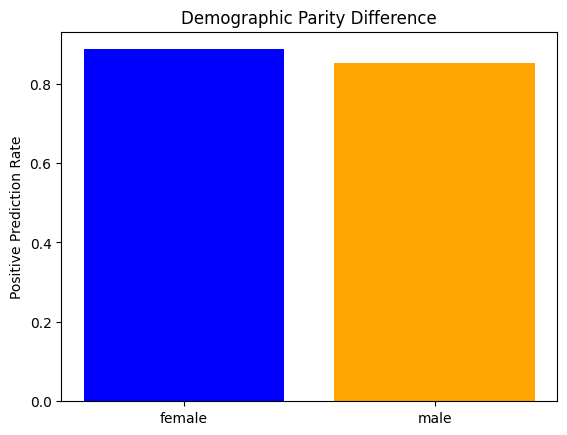

In [38]:
A_test_sex = A_test['SEX'].tolist()
rates = [sum(preds[i] for i in range(len(A_test_sex)) if A_test_sex[i] == group) / A_test_sex.count(group) for group in groups]
plt.bar(groups, rates, color=['blue', 'orange'])
plt.title("Demographic Parity Difference")
plt.ylabel("Positive Prediction Rate")
plt.show()

In [39]:
# Razlike v pravilno pozitivnih deležih
trp_diff = true_positive_rate_difference(y_test, preds, sensitive_features=A_test['SEX'])
print(f"True Positive Rate Difference: {trp_diff}")

True Positive Rate Difference: 0.0185337700935726


In [40]:
# Razlike v napačno pozitivnih deležih
fpr_diff = false_positive_rate_difference(y_test, preds, sensitive_features=A_test['SEX'])
print(f"False Positive Rate Difference: {fpr_diff}")

False Positive Rate Difference: 0.03322505586656521


#### Senzitivna spremenljivka 'SEX_EDUCATION' 

In [41]:
classifier_std_ = Pipeline(
    steps=[
        ('preprocessing', MinMaxScaler()),
        ('classifier', RandomForestClassifier()),
    ]
)

In [43]:
# učenje modela
classifier_std_.fit(X_train, y_train)

Pipeline(steps=[('preprocessing', MinMaxScaler()),
                ('classifier', RandomForestClassifier())])

In [46]:
# napovedi nad testnimi podatki
preds_ = classifier_std_.predict(X_test)
print(preds_, preds_.shape)

[1 1 1 ... 1 1 0] (6000,)


Evalvacija modelov:

In [47]:
# Natančnost za posamezno senzitivno skupino

groups = np.unique(A_test['SEX_EDUCATION'])
group_accuracies = []
for group in groups:
    mask = A_test['SEX_EDUCATION'] == group
    group_accuracy = accuracy_score(y_test[mask], preds_[mask])
    group_accuracies.append(group_accuracy)
    print(f"Accuracy for group {group}: {group_accuracy:.2f}")

Accuracy for group female_edu1: 0.84
Accuracy for group female_edu2: 0.82
Accuracy for group female_edu3: 0.80
Accuracy for group female_edu_other: 0.91
Accuracy for group male_edu1: 0.82
Accuracy for group male_edu2: 0.79
Accuracy for group male_edu3: 0.75
Accuracy for group male_edu_other: 0.82


In [48]:
# Razlike v demografski enakosti
dp_diff = demographic_parity_difference(y_test, preds_, sensitive_features=A_test['SEX_EDUCATION'])
print(f"Demographic Parity Difference: {dp_diff}")

Demographic Parity Difference: 0.13255170167725128


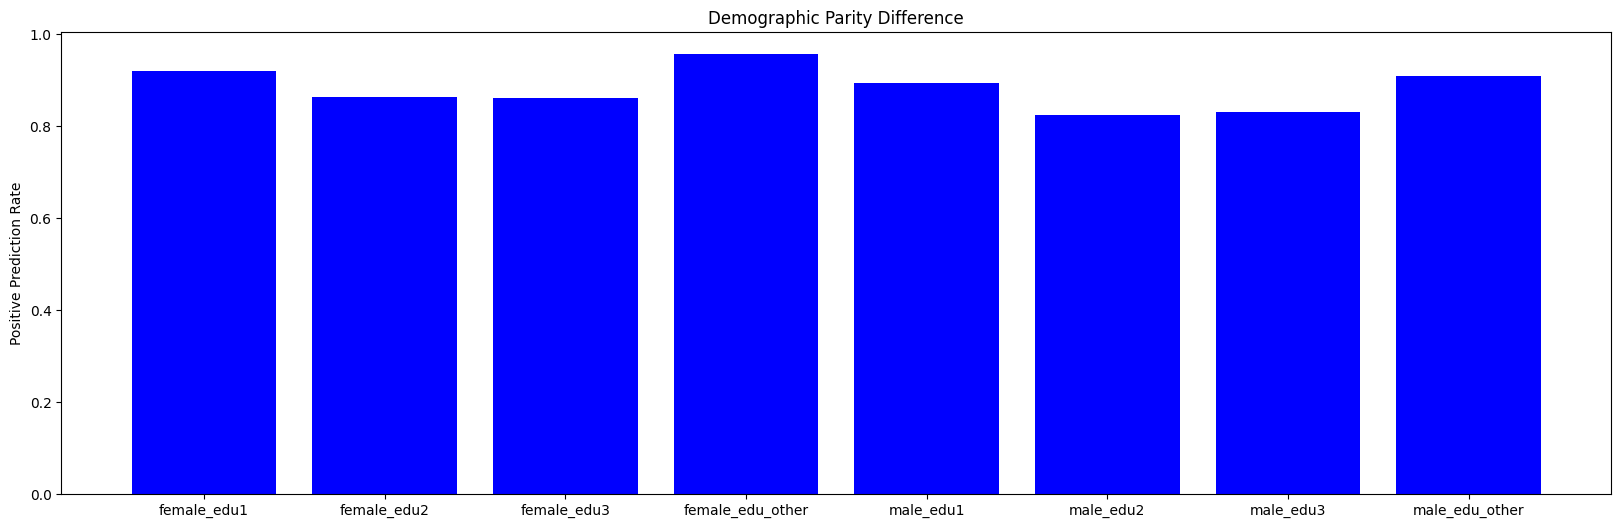

In [49]:
A_test_sexedu = A_test['SEX_EDUCATION'].tolist()
rates = [sum(preds_[i] for i in range(len(A_test_sexedu)) if A_test_sexedu[i] == group) / A_test_sexedu.count(group) for group in groups]
plt.figure(figsize=(20,6))
plt.bar(groups, rates, color=['blue'])
plt.title("Demographic Parity Difference")
plt.ylabel("Positive Prediction Rate")
plt.show()

In [50]:
# Razlike v pravilno pozitivnih deležih
trp_diff = true_positive_rate_difference(y_test, preds_, sensitive_features=A_test['SEX_EDUCATION'])
print(f"True Positive Rate Difference: {trp_diff}")

True Positive Rate Difference: 0.08387096774193548


In [51]:
# Razlike v napačno pozitivnih deležih
fpr_diff = false_positive_rate_difference(y_test, preds_, sensitive_features=A_test['SEX_EDUCATION'])
print(f"False Positive Rate Difference: {fpr_diff}")

False Positive Rate Difference: 0.43214285714285716


### FairClassifierV1

Pri FairClassifierV1 vsak model vrne napoved za pripadajoče instance, glede na to na kateri senzitivni skupini je bil naučen model.

#### Senzitivna spremenljvika 'SEX'

In [65]:
classifier_v1 = Pipeline(
    steps=[
        ('preprocessing', CustomMinMaxScaler()),
        ('classifier', FairClassifierV1(RandomForestClassifier)),
    ]
)

In [66]:
# učenje modela
classifier_v1.fit((X_train, A_train['SEX']), y_train)

Pipeline(steps=[('preprocessing', CustomMinMaxScaler()),
                ('classifier',
                 FairClassifierV1(clf_type=<class 'sklearn.ensemble._forest.RandomForestClassifier'>))])

In [67]:
# interni modeli in razredi klasifikatorja
print(classifier_v1['classifier'].models)
print(classifier_v1['classifier'].classes_)

{'female': RandomForestClassifier(), 'male': RandomForestClassifier()}
[0 1]


In [68]:
# napovedi nad testnimi podatki
preds_v1 = classifier_v1.predict((X_test, A_test['SEX']))
print(preds_v1, preds_v1.shape)

[1 1 1 ... 1 1 0] (6000,)


C:\Users\dejan\AppData\Local\pypoetry\Cache\virtualenvs\magistrska-projekt-eHWh96MI-py3.12\Lib\site-packages\sklearn\pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


Evalvacija modelov:

In [69]:
# Natančnost za posamezno senzitivno skupino

groups = np.unique(A_test['SEX'])
group_accuracies = []
for group in groups:
    mask = A_test['SEX'] == group
    group_accuracy = accuracy_score(y_test[mask], preds_v1[mask])
    group_accuracies.append(group_accuracy)
    print(f"Accuracy for group {group}: {group_accuracy:.2f}")

Accuracy for group female: 0.83
Accuracy for group male: 0.79


In [70]:
# Razlike v demografski enakosti
dp_diff = demographic_parity_difference(y_test, preds_v1, sensitive_features=A_test['SEX'])
print(f"Demographic Parity Difference: {dp_diff}")

Demographic Parity Difference: 0.049121637432886


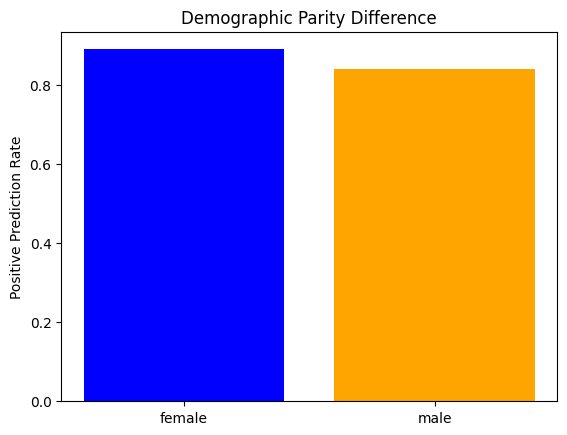

In [71]:
A_test_sex = A_test['SEX'].tolist()
rates = [sum(preds_v1[i] for i in range(len(A_test_sex)) if A_test_sex[i] == group) / A_test_sex.count(group) for group in groups]
plt.bar(groups, rates, color=['blue', 'orange'])
plt.title("Demographic Parity Difference")
plt.ylabel("Positive Prediction Rate")
plt.show()

In [72]:
# Razlike v pravilno pozitivnih deležih
trp_diff = true_positive_rate_difference(y_test, preds_v1, sensitive_features=A_test['SEX'])
print(f"True Positive Rate Difference: {trp_diff}")

True Positive Rate Difference: 0.03218388662250915


In [73]:
# Razlike v napačno pozitivnih deležih
fpr_diff = false_positive_rate_difference(y_test, preds_v1, sensitive_features=A_test['SEX'])
print(f"False Positive Rate Difference: {fpr_diff}")

False Positive Rate Difference: 0.04949662496832308


#### Senzitivna spremenljivka 'SEX_EDUCATION' 

In [74]:
classifier_v1_ = Pipeline(
    steps=[
        ('preprocessing', CustomMinMaxScaler()),
        ('classifier', FairClassifierV1(RandomForestClassifier)),
    ]
)

In [75]:
# učenje modela
classifier_v1_.fit((X_train, A_train['SEX_EDUCATION']), y_train)

Pipeline(steps=[('preprocessing', CustomMinMaxScaler()),
                ('classifier',
                 FairClassifierV1(clf_type=<class 'sklearn.ensemble._forest.RandomForestClassifier'>))])

In [76]:
# interni modeli in razredi klasifikatorja
print(classifier_v1_['classifier'].models)
print(classifier_v1_['classifier'].classes_)

{'female_edu1': RandomForestClassifier(), 'female_edu2': RandomForestClassifier(), 'female_edu3': RandomForestClassifier(), 'female_edu_other': RandomForestClassifier(), 'male_edu1': RandomForestClassifier(), 'male_edu2': RandomForestClassifier(), 'male_edu3': RandomForestClassifier(), 'male_edu_other': RandomForestClassifier()}
[0 1]


In [77]:
# napovedi nad testnimi podatki
preds_v1_ = classifier_v1_.predict((X_test, A_test['SEX_EDUCATION']))
print(preds_v1_, preds_v1_.shape)

[1 1 1 ... 1 1 0] (6000,)


C:\Users\dejan\AppData\Local\pypoetry\Cache\virtualenvs\magistrska-projekt-eHWh96MI-py3.12\Lib\site-packages\sklearn\pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


Evalvacija modelov:

In [78]:
# Natančnost za posamezno senzitivno skupino

groups = np.unique(A_test['SEX_EDUCATION'])
group_accuracies = []
for group in groups:
    mask = A_test['SEX_EDUCATION'] == group
    group_accuracy = accuracy_score(y_test[mask], preds_v1_[mask])
    group_accuracies.append(group_accuracy)
    print(f"Accuracy for group {group}: {group_accuracy:.2f}")

Accuracy for group female_edu1: 0.84
Accuracy for group female_edu2: 0.81
Accuracy for group female_edu3: 0.80
Accuracy for group female_edu_other: 0.90
Accuracy for group male_edu1: 0.81
Accuracy for group male_edu2: 0.78
Accuracy for group male_edu3: 0.75
Accuracy for group male_edu_other: 0.94


In [79]:
# Razlike v demografski enakosti
dp_diff = demographic_parity_difference(y_test, preds_v1_, sensitive_features=A_test['SEX_EDUCATION'])
print(f"Demographic Parity Difference: {dp_diff}")

Demographic Parity Difference: 0.18781725888324874


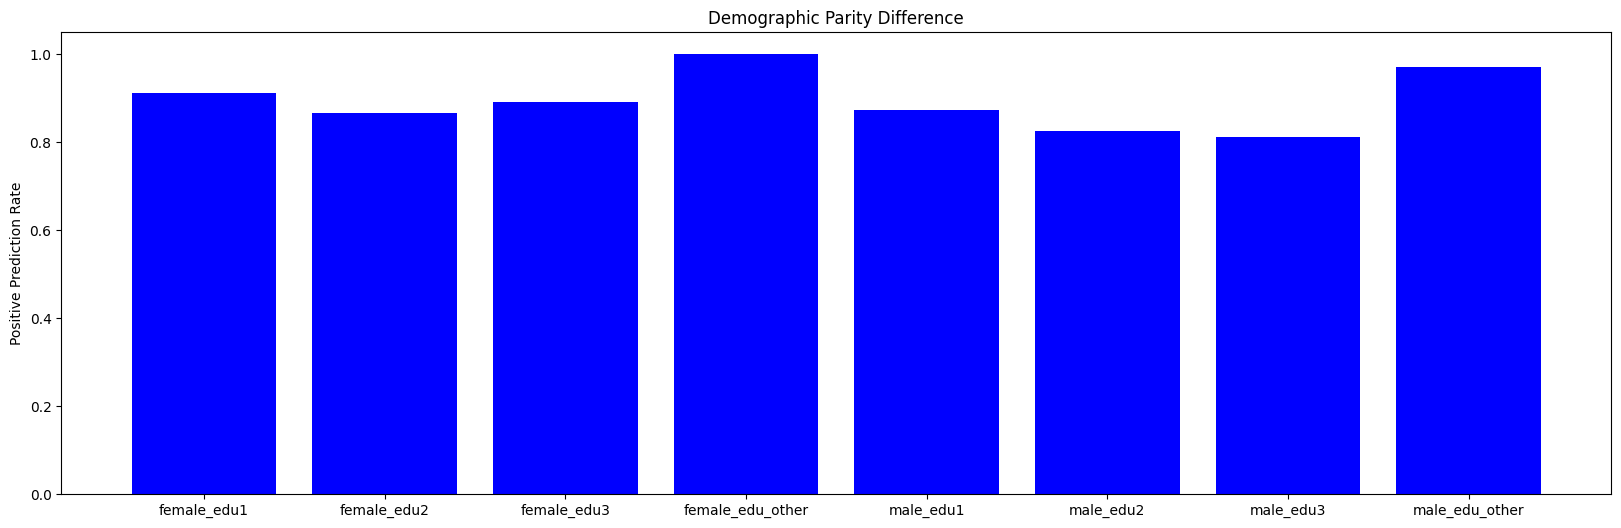

In [80]:
A_test_sexedu = A_test['SEX_EDUCATION'].tolist()
rates = [sum(preds_v1_[i] for i in range(len(A_test_sexedu)) if A_test_sexedu[i] == group) / A_test_sexedu.count(group) for group in groups]
plt.figure(figsize=(20,6))
plt.bar(groups, rates, color=['blue'])
plt.title("Demographic Parity Difference")
plt.ylabel("Positive Prediction Rate")
plt.show()

In [81]:
# Razlike v pravilno pozitivnih deležih
trp_diff = true_positive_rate_difference(y_test, preds_v1_, sensitive_features=A_test['SEX_EDUCATION'])
print(f"True Positive Rate Difference: {trp_diff}")

True Positive Rate Difference: 0.0945454545454546


In [82]:
# Razlike v napačno pozitivnih deležih
fpr_diff = false_positive_rate_difference(y_test, preds_v1_, sensitive_features=A_test['SEX_EDUCATION'])
print(f"False Positive Rate Difference: {fpr_diff}")

False Positive Rate Difference: 0.4107142857142857


### FairClassifierV2

Pri FairClassifierV2 vsak interni model poda verjetnosti napovedi za vsak razred. Za vsak razred nato seštejemo verjetnosti, pri čemer je izbran razred za določeno instanco tisti, ki ima največjo skupno vrednost verjetnosti.

#### Senzitivna spremenljvika 'SEX'

In [83]:
classifier_v2 = Pipeline(
    steps=[
        ('preprocessing', CustomMinMaxScaler()),
        ('classifier', FairClassifierV2(RandomForestClassifier)),
    ]
)

In [84]:
# učenje modela
classifier_v2.fit((X_train, A_train['SEX']), y_train)

Pipeline(steps=[('preprocessing', CustomMinMaxScaler()),
                ('classifier',
                 FairClassifierV2(clf_type=<class 'sklearn.ensemble._forest.RandomForestClassifier'>))])

In [85]:
# interni modeli in razredi klasifikatorja
print(classifier_v2['classifier'].models)
print(classifier_v2['classifier'].classes_)

{'female': RandomForestClassifier(), 'male': RandomForestClassifier()}
[0 1]


In [88]:
# napovedi nad testnimi podatki
preds_v2 = classifier_v2.predict(X_test)
print(preds_v2, preds_v2.shape)

[1 1 1 ... 1 1 0] (6000,)


C:\Users\dejan\AppData\Local\pypoetry\Cache\virtualenvs\magistrska-projekt-eHWh96MI-py3.12\Lib\site-packages\sklearn\pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


Evalvacija modelov:

In [89]:
# Natančnost za posamezno senzitivno skupino

groups = np.unique(A_test['SEX'])
group_accuracies = []
for group in groups:
    mask = A_test['SEX'] == group
    group_accuracy = accuracy_score(y_test[mask], preds_v2[mask])
    group_accuracies.append(group_accuracy)
    print(f"Accuracy for group {group}: {group_accuracy:.2f}")

Accuracy for group female: 0.83
Accuracy for group male: 0.80


In [90]:
# Razlike v demografski enakosti
dp_diff = demographic_parity_difference(y_test, preds_v2, sensitive_features=A_test['SEX'])
print(f"Demographic Parity Difference: {dp_diff}")

Demographic Parity Difference: 0.03593119551377033


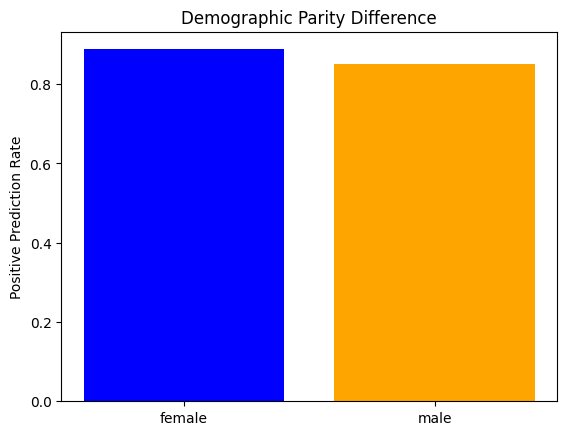

In [91]:
A_test_sex = A_test['SEX'].tolist()
rates = [sum(preds_v2[i] for i in range(len(A_test_sex)) if A_test_sex[i] == group) / A_test_sex.count(group) for group in groups]
plt.bar(groups, rates, color=['blue', 'orange'])
plt.title("Demographic Parity Difference")
plt.ylabel("Positive Prediction Rate")
plt.show()

In [92]:
# Razlike v pravilno pozitivnih deležih
trp_diff = true_positive_rate_difference(y_test, preds_v2, sensitive_features=A_test['SEX'])
print(f"True Positive Rate Difference: {trp_diff}")

True Positive Rate Difference: 0.018752771493783627


In [93]:
# Razlike v napačno pozitivnih deležih
fpr_diff = false_positive_rate_difference(y_test, preds_v2, sensitive_features=A_test['SEX'])
print(f"False Positive Rate Difference: {fpr_diff}")

False Positive Rate Difference: 0.03368581104430168


#### Senzitivna spremenljivka 'SEX_EDUCATION' 

In [94]:
classifier_v2_ = Pipeline(
    steps=[
        ('preprocessing', CustomMinMaxScaler()),
        ('classifier', FairClassifierV2(RandomForestClassifier)),
    ]
)

In [95]:
# učenje modela
classifier_v2_.fit((X_train, A_train['SEX_EDUCATION']), y_train)

Pipeline(steps=[('preprocessing', CustomMinMaxScaler()),
                ('classifier',
                 FairClassifierV2(clf_type=<class 'sklearn.ensemble._forest.RandomForestClassifier'>))])

In [96]:
# interni modeli in razredi klasifikatorja
print(classifier_v2_['classifier'].models)
print(classifier_v2_['classifier'].classes_)

{'female_edu1': RandomForestClassifier(), 'female_edu2': RandomForestClassifier(), 'female_edu3': RandomForestClassifier(), 'female_edu_other': RandomForestClassifier(), 'male_edu1': RandomForestClassifier(), 'male_edu2': RandomForestClassifier(), 'male_edu3': RandomForestClassifier(), 'male_edu_other': RandomForestClassifier()}
[0 1]


In [97]:
# napovedi nad testnimi podatki
preds_v2_ = classifier_v2.predict(X_test)
print(preds_v2_, preds_v2_.shape)

[1 1 1 ... 1 1 0] (6000,)


C:\Users\dejan\AppData\Local\pypoetry\Cache\virtualenvs\magistrska-projekt-eHWh96MI-py3.12\Lib\site-packages\sklearn\pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


Evalvacija modelov:

In [98]:
# Natančnost za posamezno senzitivno skupino

groups = np.unique(A_test['SEX_EDUCATION'])
group_accuracies = []
for group in groups:
    mask = A_test['SEX_EDUCATION'] == group
    group_accuracy = accuracy_score(y_test[mask], preds_v2_[mask])
    group_accuracies.append(group_accuracy)
    print(f"Accuracy for group {group}: {group_accuracy:.2f}")

Accuracy for group female_edu1: 0.84
Accuracy for group female_edu2: 0.83
Accuracy for group female_edu3: 0.80
Accuracy for group female_edu_other: 0.90
Accuracy for group male_edu1: 0.82
Accuracy for group male_edu2: 0.79
Accuracy for group male_edu3: 0.78
Accuracy for group male_edu_other: 0.85


In [99]:
# Razlike v demografski enakosti
dp_diff = demographic_parity_difference(y_test, preds_v2_, sensitive_features=A_test['SEX_EDUCATION'])
print(f"Demographic Parity Difference: {dp_diff}")

Demographic Parity Difference: 0.11993160723009277


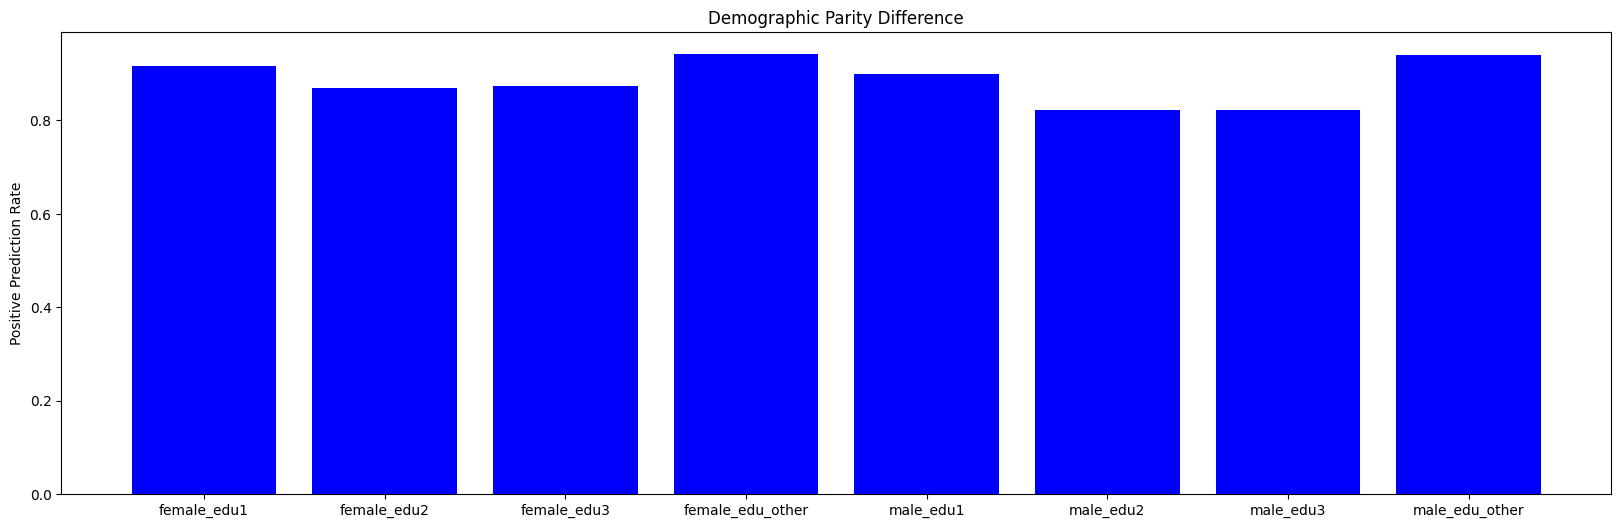

In [100]:
A_test_sexedu = A_test['SEX_EDUCATION'].tolist()
rates = [sum(preds_v2_[i] for i in range(len(A_test_sexedu)) if A_test_sexedu[i] == group) / A_test_sexedu.count(group) for group in groups]
plt.figure(figsize=(20,6))
plt.bar(groups, rates, color=['blue'])
plt.title("Demographic Parity Difference")
plt.ylabel("Positive Prediction Rate")
plt.show()

In [101]:
# Razlike v pravilno pozitivnih deležih
trp_diff = true_positive_rate_difference(y_test, preds_v2_, sensitive_features=A_test['SEX_EDUCATION'])
print(f"True Positive Rate Difference: {trp_diff}")

True Positive Rate Difference: 0.051498280661535945


In [102]:
# Razlike v napačno pozitivnih deležih
fpr_diff = false_positive_rate_difference(y_test, preds_v2_, sensitive_features=A_test['SEX_EDUCATION'])
print(f"False Positive Rate Difference: {fpr_diff}")

False Positive Rate Difference: 0.44285714285714284


### FairClassifierV3

Pri FairClassifierV3, podobno kot pri V2 vsak model poda verjetnost za vsak razred. Napovedane verjetnosti modelov nato pomnožimo z natančnostjo modela na učnih podatkih, verjetnosti na koncu seštejemo in izberemo razred z največjo vrednostjo.

#### Senzitivna spremenljvika 'SEX'

In [103]:
classifier_v3 = Pipeline(
    steps=[
        ('preprocessing', CustomMinMaxScaler()),
        ('classifier', FairClassifierV3(RandomForestClassifier)),
    ]
)

In [104]:
# učenje modela
classifier_v3.fit((X_train, A_train['SEX']), y_train)

Pipeline(steps=[('preprocessing', CustomMinMaxScaler()),
                ('classifier',
                 FairClassifierV3(clf_type=<class 'sklearn.ensemble._forest.RandomForestClassifier'>))])

In [105]:
# interni modeli, natančnosti modelov na učnih podatkih in razredi klasifikatorja
print(classifier_v3['classifier'].models)
print(classifier_v3['classifier'].scores)
print(classifier_v3['classifier'].classes_)

{'female': RandomForestClassifier(), 'male': RandomForestClassifier()}
{'model_female': 0.9137916666666667, 'model_male': 0.88825}
[0 1]


In [106]:
# napovedi nad testnimi podatki
preds_v3 = classifier_v3.predict(X_test)
print(preds_v3, preds_v3.shape)

[1 1 1 ... 1 1 0] (6000,)


C:\Users\dejan\AppData\Local\pypoetry\Cache\virtualenvs\magistrska-projekt-eHWh96MI-py3.12\Lib\site-packages\sklearn\pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


Evalvacija modelov:

In [107]:
# Natančnost za posamezno senzitivno skupino

groups = np.unique(A_test['SEX'])
group_accuracies = []
for group in groups:
    mask = A_test['SEX'] == group
    group_accuracy = accuracy_score(y_test[mask], preds_v3[mask])
    group_accuracies.append(group_accuracy)
    print(f"Accuracy for group {group}: {group_accuracy:.2f}")

Accuracy for group female: 0.83
Accuracy for group male: 0.80


In [108]:
# Razlike v demografski enakosti
dp_diff = demographic_parity_difference(y_test, preds_v3, sensitive_features=A_test['SEX'])
print(f"Demographic Parity Difference: {dp_diff}")

Demographic Parity Difference: 0.0354006097200712


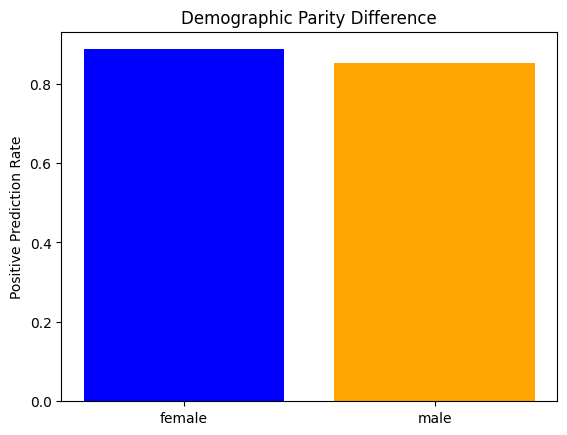

In [109]:
A_test_sex = A_test['SEX'].tolist()
rates = [sum(preds_v3[i] for i in range(len(A_test_sex)) if A_test_sex[i] == group) / A_test_sex.count(group) for group in groups]
plt.bar(groups, rates, color=['blue', 'orange'])
plt.title("Demographic Parity Difference")
plt.ylabel("Positive Prediction Rate")
plt.show()

In [110]:
# Razlike v pravilno pozitivnih deležih
trp_diff = true_positive_rate_difference(y_test, preds_v3, sensitive_features=A_test['SEX'])
print(f"True Positive Rate Difference: {trp_diff}")

True Positive Rate Difference: 0.015339417223295126


In [111]:
# Razlike v napačno pozitivnih deležih
fpr_diff = false_positive_rate_difference(y_test, preds_v3, sensitive_features=A_test['SEX'])
print(f"False Positive Rate Difference: {fpr_diff}")

False Positive Rate Difference: 0.0422328195913102


#### Senzitivna spremenljivka 'SEX_EDUCATION' 

In [112]:
classifier_v3_ = Pipeline(
    steps=[
        ('preprocessing', CustomMinMaxScaler()),
        ('classifier', FairClassifierV3(RandomForestClassifier)),
    ]
)

In [113]:
# učenje modela
classifier_v3_.fit((X_train, A_train['SEX_EDUCATION']), y_train)

Pipeline(steps=[('preprocessing', CustomMinMaxScaler()),
                ('classifier',
                 FairClassifierV3(clf_type=<class 'sklearn.ensemble._forest.RandomForestClassifier'>))])

In [114]:
# interni modeli in razredi klasifikatorja
print(classifier_v3_['classifier'].models)
print(classifier_v3_['classifier'].classes_)

{'female_edu1': RandomForestClassifier(), 'female_edu2': RandomForestClassifier(), 'female_edu3': RandomForestClassifier(), 'female_edu_other': RandomForestClassifier(), 'male_edu1': RandomForestClassifier(), 'male_edu2': RandomForestClassifier(), 'male_edu3': RandomForestClassifier(), 'male_edu_other': RandomForestClassifier()}
[0 1]


In [115]:
# napovedi nad testnimi podatki
preds_v3_ = classifier_v3_.predict(X_test)
print(preds_v3_, preds_v3_.shape)

[1 1 1 ... 1 1 0] (6000,)


C:\Users\dejan\AppData\Local\pypoetry\Cache\virtualenvs\magistrska-projekt-eHWh96MI-py3.12\Lib\site-packages\sklearn\pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


Evalvacija modelov:

In [116]:
# Natančnost za posamezno senzitivno skupino

groups = np.unique(A_test['SEX_EDUCATION'])
group_accuracies = []
for group in groups:
    mask = A_test['SEX_EDUCATION'] == group
    group_accuracy = accuracy_score(y_test[mask], preds_v3_[mask])
    group_accuracies.append(group_accuracy)
    print(f"Accuracy for group {group}: {group_accuracy:.2f}")

Accuracy for group female_edu1: 0.84
Accuracy for group female_edu2: 0.82
Accuracy for group female_edu3: 0.80
Accuracy for group female_edu_other: 0.93
Accuracy for group male_edu1: 0.81
Accuracy for group male_edu2: 0.80
Accuracy for group male_edu3: 0.76
Accuracy for group male_edu_other: 0.88


In [117]:
# Razlike v demografski enakosti
dp_diff = demographic_parity_difference(y_test, preds_v3_, sensitive_features=A_test['SEX_EDUCATION'])
print(f"Demographic Parity Difference: {dp_diff}")

Demographic Parity Difference: 0.07253733539321705


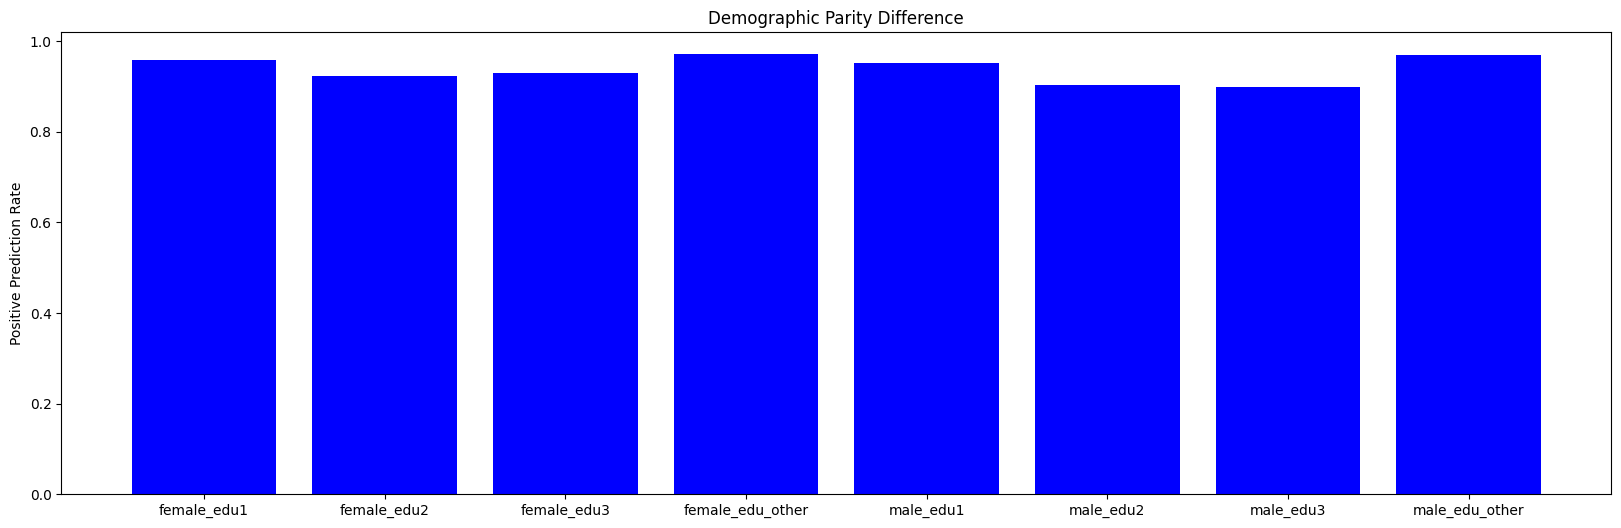

In [118]:
A_test_sexedu = A_test['SEX_EDUCATION'].tolist()
rates = [sum(preds_v3_[i] for i in range(len(A_test_sexedu)) if A_test_sexedu[i] == group) / A_test_sexedu.count(group) for group in groups]
plt.figure(figsize=(20,6))
plt.bar(groups, rates, color=['blue'])
plt.title("Demographic Parity Difference")
plt.ylabel("Positive Prediction Rate")
plt.show()

In [119]:
# Razlike v pravilno pozitivnih deležih
trp_diff = true_positive_rate_difference(y_test, preds_v3_, sensitive_features=A_test['SEX_EDUCATION'])
print(f"True Positive Rate Difference: {trp_diff}")

True Positive Rate Difference: 0.033333333333333326


In [120]:
# Razlike v napačno pozitivnih deležih
fpr_diff = false_positive_rate_difference(y_test, preds_v3_, sensitive_features=A_test['SEX_EDUCATION'])
print(f"False Positive Rate Difference: {fpr_diff}")

False Positive Rate Difference: 0.2964285714285714


### FairClassifierV4

FairClassifierV4 dela enako kot V3, le da v tem primeru verjetnosti razredov pomnožimo z natančnostjo modela nad učnimi podatki določene senzitivne skupine, glede na instanco, za katero model podaja napoved.

#### Senzitivna spremenljvika 'SEX'

In [121]:
classifier_v4 = Pipeline(
    steps=[
        ('preprocessing', CustomMinMaxScaler()),
        ('classifier', FairClassifierV4(RandomForestClassifier)),
    ]
)

In [122]:
# učenje modela
classifier_v4.fit((X_train, A_train['SEX']), y_train)

Pipeline(steps=[('preprocessing', CustomMinMaxScaler()),
                ('classifier',
                 FairClassifierV4(clf_type=<class 'sklearn.ensemble._forest.RandomForestClassifier'>))])

In [123]:
# interni modeli, natančnosti modelov na učnih podatkih in razredi klasifikatorja
print(classifier_v4['classifier'].models)
print(classifier_v4['classifier'].scores)
print(classifier_v4['classifier'].classes_)

{'female': RandomForestClassifier(), 'male': RandomForestClassifier()}
{'model_female': {'female': 0.9920569139383892, 'male': 0.796471329552615}, 'model_male': {'female': 0.8184832159138002, 'male': 0.9931737030035707}}
[0 1]


In [124]:
# napovedi nad testnimi podatki
preds_v4 = classifier_v4.predict((X_test, A_test['SEX']))
print(preds_v4, preds_v4.shape)

[1 1 1 ... 1 1 0] (6000,)


C:\Users\dejan\AppData\Local\pypoetry\Cache\virtualenvs\magistrska-projekt-eHWh96MI-py3.12\Lib\site-packages\sklearn\pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


Evalvacija modelov:

In [125]:
# Natančnost za posamezno senzitivno skupino

groups = np.unique(A_test['SEX'])
group_accuracies = []
for group in groups:
    mask = A_test['SEX'] == group
    group_accuracy = accuracy_score(y_test[mask], preds_v4[mask])
    group_accuracies.append(group_accuracy)
    print(f"Accuracy for group {group}: {group_accuracy:.2f}")

Accuracy for group female: 0.83
Accuracy for group male: 0.80


In [126]:
# Razlike v demografski enakosti
dp_diff = demographic_parity_difference(y_test, preds_v4, sensitive_features=A_test['SEX'])
print(f"Demographic Parity Difference: {dp_diff}")

Demographic Parity Difference: 0.03468300464617302


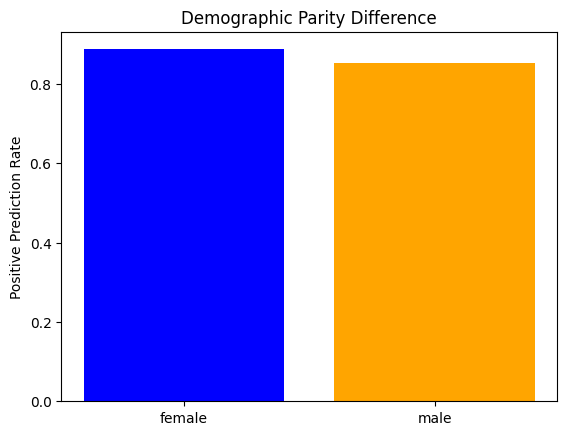

In [127]:
A_test_sex = A_test['SEX'].tolist()
rates = [sum(preds_v4[i] for i in range(len(A_test_sex)) if A_test_sex[i] == group) / A_test_sex.count(group) for group in groups]
plt.bar(groups, rates, color=['blue', 'orange'])
plt.title("Demographic Parity Difference")
plt.ylabel("Positive Prediction Rate")
plt.show()

In [128]:
# Razlike v pravilno pozitivnih deležih
trp_diff = true_positive_rate_difference(y_test, preds_v4, sensitive_features=A_test['SEX'])
print(f"True Positive Rate Difference: {trp_diff}")

True Positive Rate Difference: 0.01814682878983087


In [129]:
# Razlike v napačno pozitivnih deležih
fpr_diff = false_positive_rate_difference(y_test, preds_v4, sensitive_features=A_test['SEX'])
print(f"False Positive Rate Difference: {fpr_diff}")

False Positive Rate Difference: 0.03125302370585381


#### Senzitivna spremenljivka 'SEX_EDUCATION' 

In [130]:
classifier_v4_ = Pipeline(
    steps=[
        ('preprocessing', CustomMinMaxScaler()),
        ('classifier', FairClassifierV1(RandomForestClassifier)),
    ]
)

In [131]:
# učenje modela
classifier_v4_.fit((X_train, A_train['SEX_EDUCATION']), y_train)

Pipeline(steps=[('preprocessing', CustomMinMaxScaler()),
                ('classifier',
                 FairClassifierV1(clf_type=<class 'sklearn.ensemble._forest.RandomForestClassifier'>))])

In [132]:
# interni modeli in razredi klasifikatorja
print(classifier_v4_['classifier'].models)
print(classifier_v4_['classifier'].classes_)

{'female_edu1': RandomForestClassifier(), 'female_edu2': RandomForestClassifier(), 'female_edu3': RandomForestClassifier(), 'female_edu_other': RandomForestClassifier(), 'male_edu1': RandomForestClassifier(), 'male_edu2': RandomForestClassifier(), 'male_edu3': RandomForestClassifier(), 'male_edu_other': RandomForestClassifier()}
[0 1]


In [133]:
# napovedi nad testnimi podatki
preds_v4_ = classifier_v4_.predict((X_test, A_test['SEX_EDUCATION']))
print(preds_v4_, preds_v4_.shape)

[1 1 1 ... 1 1 0] (6000,)


C:\Users\dejan\AppData\Local\pypoetry\Cache\virtualenvs\magistrska-projekt-eHWh96MI-py3.12\Lib\site-packages\sklearn\pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


Evalvacija modelov:

In [134]:
# Natančnost za posamezno senzitivno skupino

groups = np.unique(A_test['SEX_EDUCATION'])
group_accuracies = []
for group in groups:
    mask = A_test['SEX_EDUCATION'] == group
    group_accuracy = accuracy_score(y_test[mask], preds_v4_[mask])
    group_accuracies.append(group_accuracy)
    print(f"Accuracy for group {group}: {group_accuracy:.2f}")

Accuracy for group female_edu1: 0.84
Accuracy for group female_edu2: 0.82
Accuracy for group female_edu3: 0.79
Accuracy for group female_edu_other: 0.90
Accuracy for group male_edu1: 0.80
Accuracy for group male_edu2: 0.78
Accuracy for group male_edu3: 0.75
Accuracy for group male_edu_other: 0.94


In [135]:
# Razlike v demografski enakosti
dp_diff = demographic_parity_difference(y_test, preds_v4_, sensitive_features=A_test['SEX_EDUCATION'])
print(f"Demographic Parity Difference: {dp_diff}")

Demographic Parity Difference: 0.18781725888324874


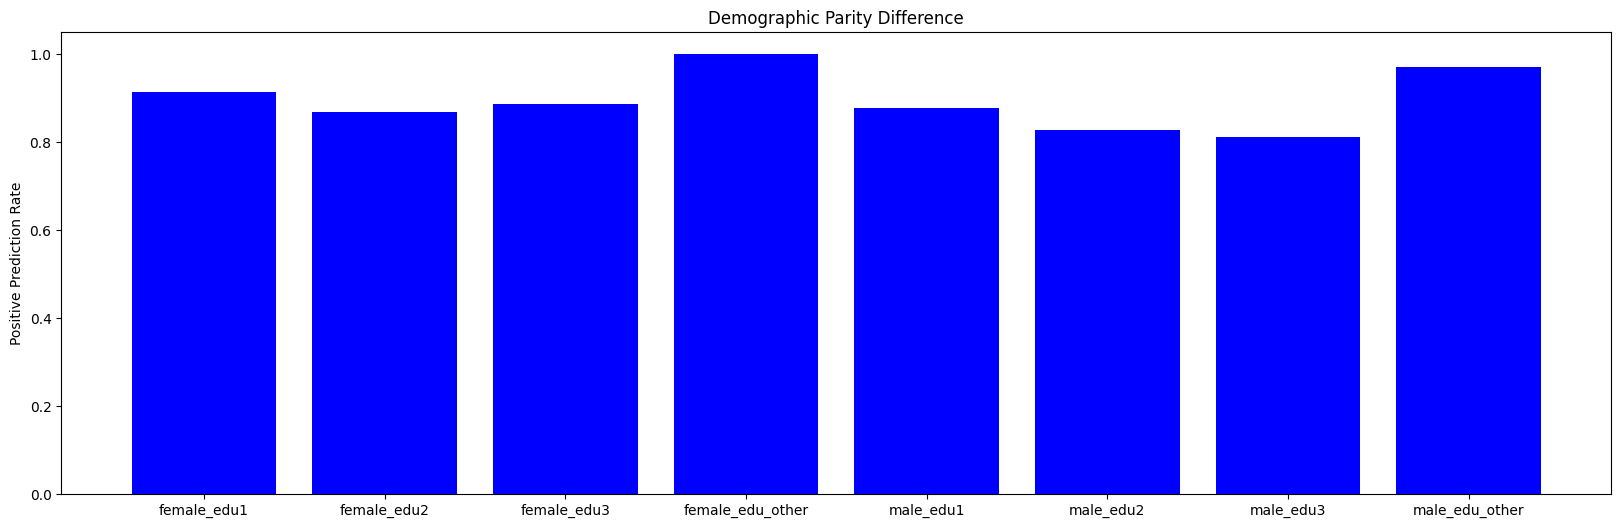

In [136]:
A_test_sexedu = A_test['SEX_EDUCATION'].tolist()
rates = [sum(preds_v4_[i] for i in range(len(A_test_sexedu)) if A_test_sexedu[i] == group) / A_test_sexedu.count(group) for group in groups]
plt.figure(figsize=(20,6))
plt.bar(groups, rates, color=['blue'])
plt.title("Demographic Parity Difference")
plt.ylabel("Positive Prediction Rate")
plt.show()

In [137]:
# Razlike v pravilno pozitivnih deležih
trp_diff = true_positive_rate_difference(y_test, preds_v4_, sensitive_features=A_test['SEX_EDUCATION'])
print(f"True Positive Rate Difference: {trp_diff}")

True Positive Rate Difference: 0.0945454545454546


In [138]:
# Razlike v napačno pozitivnih deležih
fpr_diff = false_positive_rate_difference(y_test, preds_v4_, sensitive_features=A_test['SEX_EDUCATION'])
print(f"False Positive Rate Difference: {fpr_diff}")

False Positive Rate Difference: 0.4178571428571428


### FairClassifierV5

Pri FairClassifierV5, podobno kot pri V2 vsak model poda verjetnost za vsak razred. Kot napoved vzamemo tisti razred, ki ima največjo verjetnost med napovedi vseh modelov.

#### Senzitivna spremenljvika 'SEX'

In [153]:
classifier_v5 = Pipeline(
    steps=[
        ('preprocessing', CustomMinMaxScaler()),
        ('classifier', FairClassifierV5(RandomForestClassifier)),
    ]
)

In [154]:
# učenje modela
classifier_v5.fit((X_train, A_train['SEX']), y_train)

Pipeline(steps=[('preprocessing', CustomMinMaxScaler()),
                ('classifier',
                 FairClassifierV5(clf_type=<class 'sklearn.ensemble._forest.RandomForestClassifier'>))])

In [155]:
# interni modeli in razredi klasifikatorja
print(classifier_v5['classifier'].models)
print(classifier_v5['classifier'].classes_)

{'female': RandomForestClassifier(), 'male': RandomForestClassifier()}
[0 1]


In [156]:
# napovedi nad testnimi podatki
preds_v5 = classifier_v5.predict(X_test)
print(preds_v5, preds_v5.shape)

[1 1 1 ... 1 1 0] (6000,)


C:\Users\dejan\AppData\Local\pypoetry\Cache\virtualenvs\magistrska-projekt-eHWh96MI-py3.12\Lib\site-packages\sklearn\pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


Evalvacija modelov:

In [157]:
# Natančnost za posamezno senzitivno skupino

groups = np.unique(A_test['SEX'])
group_accuracies = []
for group in groups:
    mask = A_test['SEX'] == group
    group_accuracy = accuracy_score(y_test[mask], preds_v5[mask])
    group_accuracies.append(group_accuracy)
    print(f"Accuracy for group {group}: {group_accuracy:.2f}")

Accuracy for group female: 0.83
Accuracy for group male: 0.80


In [158]:
# Razlike v demografski enakosti
dp_diff = demographic_parity_difference(y_test, preds_v5, sensitive_features=A_test['SEX'])
print(f"Demographic Parity Difference: {dp_diff}")

Demographic Parity Difference: 0.03905702273679923


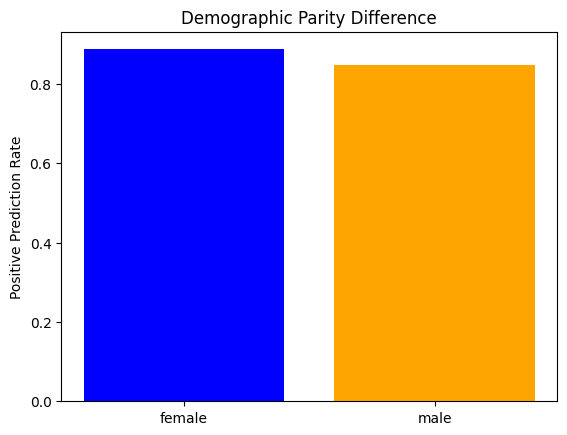

In [159]:
A_test_sex = A_test['SEX'].tolist()
rates = [sum(preds_v5[i] for i in range(len(A_test_sex)) if A_test_sex[i] == group) / A_test_sex.count(group) for group in groups]
plt.bar(groups, rates, color=['blue', 'orange'])
plt.title("Demographic Parity Difference")
plt.ylabel("Positive Prediction Rate")
plt.show()

In [160]:
# Razlike v pravilno pozitivnih deležih
trp_diff = true_positive_rate_difference(y_test, preds_v5, sensitive_features=A_test['SEX'])
print(f"True Positive Rate Difference: {trp_diff}")

True Positive Rate Difference: 0.01723956501041024


In [161]:
# Razlike v napačno pozitivnih deležih
fpr_diff = false_positive_rate_difference(y_test, preds_v5, sensitive_features=A_test['SEX'])
print(f"False Positive Rate Difference: {fpr_diff}")

False Positive Rate Difference: 0.05176584421867436


#### Senzitivna spremenljivka 'SEX_EDUCATION' 

In [162]:
classifier_v5_ = Pipeline(
    steps=[
        ('preprocessing', CustomMinMaxScaler()),
        ('classifier', FairClassifierV5(RandomForestClassifier)),
    ]
)

In [163]:
# učenje modela
classifier_v5_.fit((X_train, A_train['SEX_EDUCATION']), y_train)

Pipeline(steps=[('preprocessing', CustomMinMaxScaler()),
                ('classifier',
                 FairClassifierV5(clf_type=<class 'sklearn.ensemble._forest.RandomForestClassifier'>))])

In [164]:
# interni modeli in razredi klasifikatorja
print(classifier_v5_['classifier'].models)
print(classifier_v5_['classifier'].classes_)

{'female_edu1': RandomForestClassifier(), 'female_edu2': RandomForestClassifier(), 'female_edu3': RandomForestClassifier(), 'female_edu_other': RandomForestClassifier(), 'male_edu1': RandomForestClassifier(), 'male_edu2': RandomForestClassifier(), 'male_edu3': RandomForestClassifier(), 'male_edu_other': RandomForestClassifier()}
[0 1]


In [165]:
# napovedi nad testnimi podatki
preds_v5_ = classifier_v5_.predict(X_test)
print(preds_v5_, preds_v5_.shape)

[1 1 1 ... 1 1 1] (6000,)


C:\Users\dejan\AppData\Local\pypoetry\Cache\virtualenvs\magistrska-projekt-eHWh96MI-py3.12\Lib\site-packages\sklearn\pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


Evalvacija modelov:

In [166]:
# Natančnost za posamezno senzitivno skupino

groups = np.unique(A_test['SEX_EDUCATION'])
group_accuracies = []
for group in groups:
    mask = A_test['SEX_EDUCATION'] == group
    group_accuracy = accuracy_score(y_test[mask], preds_v5_[mask])
    group_accuracies.append(group_accuracy)
    print(f"Accuracy for group {group}: {group_accuracy:.2f}")

Accuracy for group female_edu1: 0.83
Accuracy for group female_edu2: 0.80
Accuracy for group female_edu3: 0.77
Accuracy for group female_edu_other: 0.91
Accuracy for group male_edu1: 0.80
Accuracy for group male_edu2: 0.76
Accuracy for group male_edu3: 0.73
Accuracy for group male_edu_other: 0.91


In [167]:
# Razlike v demografski enakosti
dp_diff = demographic_parity_difference(y_test, preds_v5_, sensitive_features=A_test['SEX_EDUCATION'])
print(f"Demographic Parity Difference: {dp_diff}")

Demographic Parity Difference: 0.03807106598984766


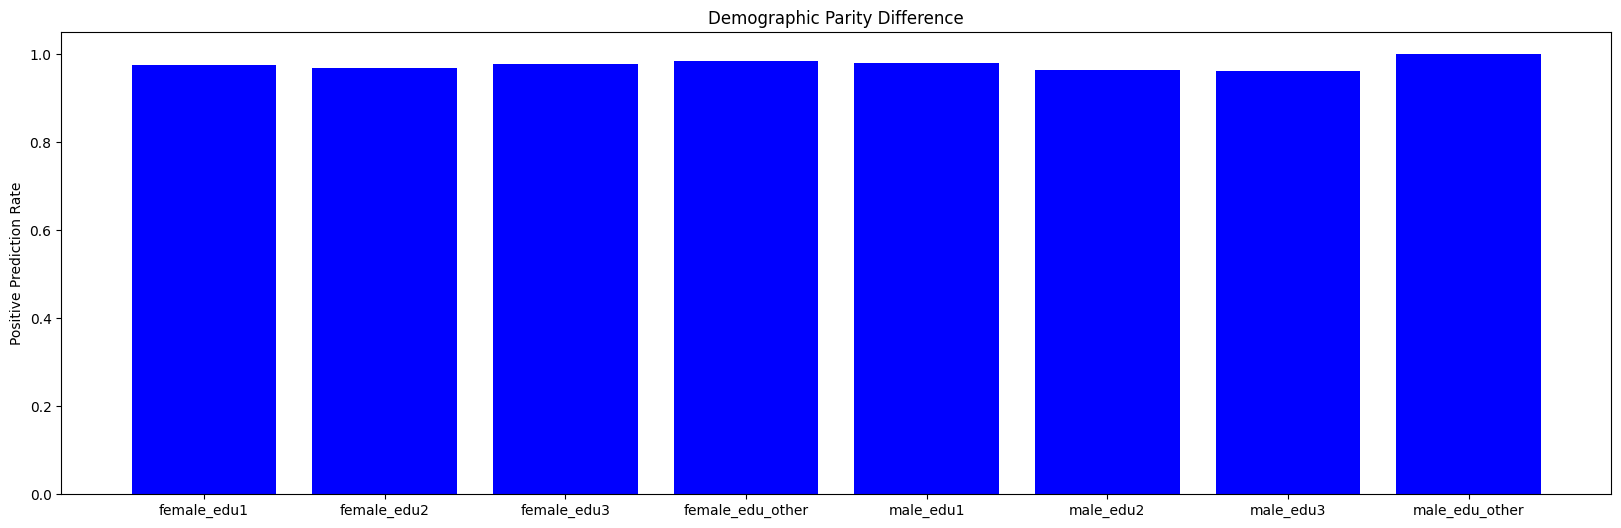

In [168]:
A_test_sexedu = A_test['SEX_EDUCATION'].tolist()
rates = [sum(preds_v5_[i] for i in range(len(A_test_sexedu)) if A_test_sexedu[i] == group) / A_test_sexedu.count(group) for group in groups]
plt.figure(figsize=(20,6))
plt.bar(groups, rates, color=['blue'])
plt.title("Demographic Parity Difference")
plt.ylabel("Positive Prediction Rate")
plt.show()

In [169]:
# Razlike v pravilno pozitivnih deležih
trp_diff = true_positive_rate_difference(y_test, preds_v5_, sensitive_features=A_test['SEX_EDUCATION'])
print(f"True Positive Rate Difference: {trp_diff}")

True Positive Rate Difference: 0.010463378176382654


In [170]:
# Razlike v napačno pozitivnih deležih
fpr_diff = false_positive_rate_difference(y_test, preds_v5_, sensitive_features=A_test['SEX_EDUCATION'])
print(f"False Positive Rate Difference: {fpr_diff}")

False Positive Rate Difference: 0.1428571428571429


### FairClassifierV6

Pri FairClassifierV6, najprej model selektor določi kateri model v ansamblu bo vrnil napoved za določeno instanco. Nato vsak model v ansamblu vrne napoved za pripadajočo instanco.

#### Senzitivna spremenljvika 'SEX'

In [179]:
classifier_v6 = Pipeline(
    steps=[
        ('preprocessing', CustomMinMaxScaler()),
        ('classifier', FairClassifierV6(RandomForestClassifier)),
    ]
)

In [180]:
# učenje modela
classifier_v6.fit((X_train, A_train['SEX']), y_train)

Pipeline(steps=[('preprocessing', CustomMinMaxScaler()),
                ('classifier',
                 FairClassifierV6(clf_type=<class 'sklearn.ensemble._forest.RandomForestClassifier'>))])

In [181]:
# interni modeli in razredi klasifikatorja
print(classifier_v6['classifier'].models)
print(classifier_v6['classifier'].classes_)

{'female': RandomForestClassifier(), 'male': RandomForestClassifier()}
[0 1]


In [184]:
# napovedi nad testnimi podatki in določeni modeli za vsako napoved
preds_v6, selector_preds = classifier_v6.predict(X_test)
print(preds_v6, preds_v6.shape)
print(selector_preds, selector_preds.shape)

[1 1 1 ... 1 1 0] (6000,)
['female' 'female' 'female' ... 'male' 'female' 'male'] (6000,)


C:\Users\dejan\AppData\Local\pypoetry\Cache\virtualenvs\magistrska-projekt-eHWh96MI-py3.12\Lib\site-packages\sklearn\pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


Evalvacija modelov:

In [185]:
# Natančnost modela selektorja pri izboru modelov za končno napoved
selector_accurcy = accuracy_score(A_test['SEX'], selector_preds)
print(f"Accuracy of selector model: {selector_accurcy:.2f}")

Accuracy of selector model: 0.61


In [186]:
# Natančnost za posamezno senzitivno skupino

groups = np.unique(A_test['SEX'])
group_accuracies = []
for group in groups:
    mask = A_test['SEX'] == group
    group_accuracy = accuracy_score(y_test[mask], preds_v6[mask])
    group_accuracies.append(group_accuracy)
    print(f"Accuracy for group {group}: {group_accuracy:.2f}")

Accuracy for group female: 0.82
Accuracy for group male: 0.79


In [187]:
# Razlike v demografski enakosti
dp_diff = demographic_parity_difference(y_test, preds_v6, sensitive_features=A_test['SEX'])
print(f"Demographic Parity Difference: {dp_diff}")

Demographic Parity Difference: 0.03313986297348559


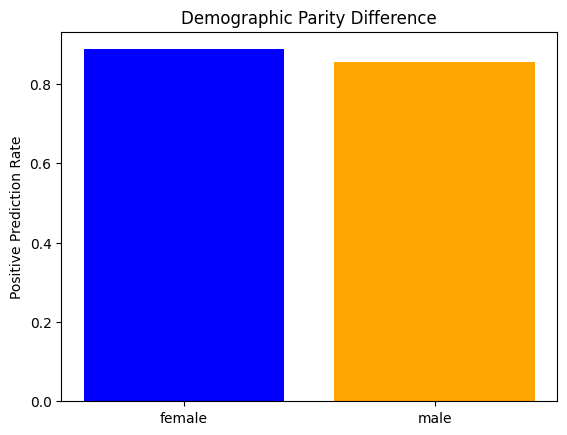

In [188]:
A_test_sex = A_test['SEX'].tolist()
rates = [sum(preds_v6[i] for i in range(len(A_test_sex)) if A_test_sex[i] == group) / A_test_sex.count(group) for group in groups]
plt.bar(groups, rates, color=['blue', 'orange'])
plt.title("Demographic Parity Difference")
plt.ylabel("Positive Prediction Rate")
plt.show()

In [190]:
# Razlike v pravilno pozitivnih deležih
trp_diff = true_positive_rate_difference(y_test, preds_v6, sensitive_features=A_test['SEX'])
print(f"True Positive Rate Difference: {trp_diff}")

True Positive Rate Difference: 0.015075955432438448


In [191]:
# Razlike v napačno pozitivnih deležih
fpr_diff = false_positive_rate_difference(y_test, preds_v6, sensitive_features=A_test['SEX'])
print(f"False Positive Rate Difference: {fpr_diff}")

False Positive Rate Difference: 0.039141152348699526


#### Senzitivna spremenljivka 'SEX_EDUCATION' 

In [192]:
classifier_v6_ = Pipeline(
    steps=[
        ('preprocessing', CustomMinMaxScaler()),
        ('classifier', FairClassifierV6(RandomForestClassifier)),
    ]
)

In [194]:
# učenje modela
classifier_v6_.fit((X_train, A_train['SEX_EDUCATION']), y_train)

Pipeline(steps=[('preprocessing', CustomMinMaxScaler()),
                ('classifier',
                 FairClassifierV6(clf_type=<class 'sklearn.ensemble._forest.RandomForestClassifier'>))])

In [195]:
# interni modeli in razredi klasifikatorja
print(classifier_v6_['classifier'].models)
print(classifier_v6_['classifier'].classes_)

{'female_edu1': RandomForestClassifier(), 'female_edu2': RandomForestClassifier(), 'female_edu3': RandomForestClassifier(), 'female_edu_other': RandomForestClassifier(), 'male_edu1': RandomForestClassifier(), 'male_edu2': RandomForestClassifier(), 'male_edu3': RandomForestClassifier(), 'male_edu_other': RandomForestClassifier()}
[0 1]


In [196]:
# napovedi nad testnimi podatki in določeni modeli za vsako napoved
preds_v6_, selector_preds_ = classifier_v6_.predict(X_test)
print(preds_v6_, preds_v6_.shape)
print(selector_preds_, selector_preds_.shape)

[1 1 1 ... 1 1 0] (6000,)
['female_edu1' 'female_edu1' 'female_edu1' ... 'male_edu2' 'female_edu1'
 'male_edu2'] (6000,)


C:\Users\dejan\AppData\Local\pypoetry\Cache\virtualenvs\magistrska-projekt-eHWh96MI-py3.12\Lib\site-packages\sklearn\pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


Evalvacija modelov:

In [197]:
# Natančnost modela selektorja pri izboru modelov za končno napoved
selector_accurcy_ = accuracy_score(A_test['SEX_EDUCATION'], selector_preds_)
print(f"Accuracy of selector model: {selector_accurcy_:.2f}")

Accuracy of selector model: 0.29


In [198]:
# Natančnost za posamezno senzitivno skupino

groups = np.unique(A_test['SEX_EDUCATION'])
group_accuracies = []
for group in groups:
    mask = A_test['SEX_EDUCATION'] == group
    group_accuracy = accuracy_score(y_test[mask], preds_v6_[mask])
    group_accuracies.append(group_accuracy)
    print(f"Accuracy for group {group}: {group_accuracy:.2f}")

Accuracy for group female_edu1: 0.83
Accuracy for group female_edu2: 0.81
Accuracy for group female_edu3: 0.79
Accuracy for group female_edu_other: 0.87
Accuracy for group male_edu1: 0.81
Accuracy for group male_edu2: 0.79
Accuracy for group male_edu3: 0.77
Accuracy for group male_edu_other: 0.85


In [199]:
# Razlike v demografski enakosti
dp_diff = demographic_parity_difference(y_test, preds_v6_, sensitive_features=A_test['SEX_EDUCATION'])
print(f"Demographic Parity Difference: {dp_diff}")

Demographic Parity Difference: 0.11355124276472595


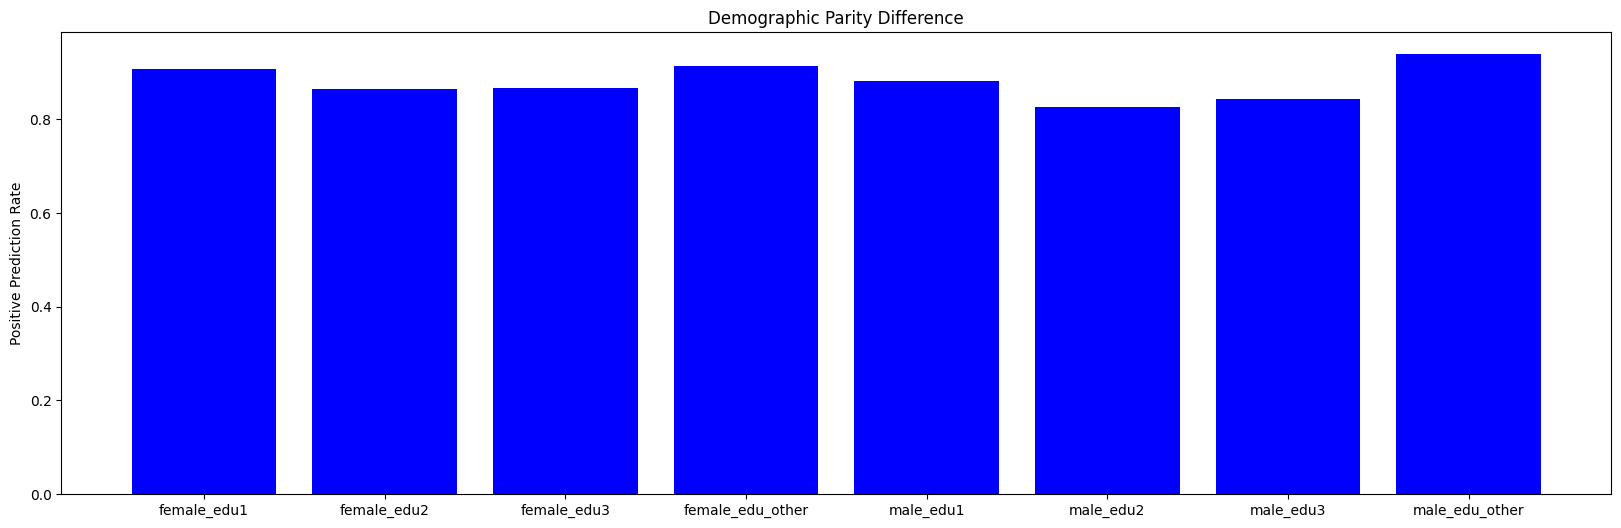

In [200]:
A_test_sexedu = A_test['SEX_EDUCATION'].tolist()
rates = [sum(preds_v6_[i] for i in range(len(A_test_sexedu)) if A_test_sexedu[i] == group) / A_test_sexedu.count(group) for group in groups]
plt.figure(figsize=(20,6))
plt.bar(groups, rates, color=['blue'])
plt.title("Demographic Parity Difference")
plt.ylabel("Positive Prediction Rate")
plt.show()

In [201]:
# Razlike v pravilno pozitivnih deležih
trp_diff = true_positive_rate_difference(y_test, preds_v6_, sensitive_features=A_test['SEX_EDUCATION'])
print(f"True Positive Rate Difference: {trp_diff}")

True Positive Rate Difference: 0.0374242988456186


In [202]:
# Razlike v napačno pozitivnih deležih
fpr_diff = false_positive_rate_difference(y_test, preds_v6_, sensitive_features=A_test['SEX_EDUCATION'])
print(f"False Positive Rate Difference: {fpr_diff}")

False Positive Rate Difference: 0.4285714285714286


### FairClassifierV7

FairClassifierV7 vsebuje končni model, ki je naučen glede na verjetnosti napovedi razredov senzitivnih modelov iz ansambla. Potem ko je vsak model v ansamblu naučen za svojo senzitivno skupino, podobno kot pri V5 vsak model poda verjetnost za vsak razred. Kot novo ciljno spremenljivko vzamemo tisti razred, ki ima največjo verjetnost med napovedi vseh modelov. Nato naučimo končni model z novimi ciljnimi spremenljivkami.

#### Senzitivna spremenljvika 'SEX'

In [204]:
classifier_v7 = Pipeline(
    steps=[
        ('preprocessing', CustomMinMaxScaler()),
        ('classifier', FairClassifierV7(RandomForestClassifier)),
    ]
)

In [205]:
# učenje modela
classifier_v7.fit((X_train, A_train['SEX']), y_train)

Pipeline(steps=[('preprocessing', CustomMinMaxScaler()),
                ('classifier',
                 FairClassifierV7(clf_type=<class 'sklearn.ensemble._forest.RandomForestClassifier'>))])

In [206]:
# interni modeli in razredi klasifikatorja
print(classifier_v7['classifier'].models)
print(classifier_v7['classifier'].classes_)

{'female': RandomForestClassifier(), 'male': RandomForestClassifier()}
[0 1]


In [207]:
# napovedi nad testnimi podatki
preds_v7 = classifier_v7.predict(X_test)
print(preds_v7, preds_v7.shape)

[1 1 1 ... 1 1 0] (6000,)


C:\Users\dejan\AppData\Local\pypoetry\Cache\virtualenvs\magistrska-projekt-eHWh96MI-py3.12\Lib\site-packages\sklearn\pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


Evalvacija modelov:

In [208]:
# Natančnost za posamezno senzitivno skupino

groups = np.unique(A_test['SEX'])
group_accuracies = []
for group in groups:
    mask = A_test['SEX'] == group
    group_accuracy = accuracy_score(y_test[mask], preds_v7[mask])
    group_accuracies.append(group_accuracy)
    print(f"Accuracy for group {group}: {group_accuracy:.2f}")

Accuracy for group female: 0.83
Accuracy for group male: 0.80


In [209]:
# Razlike v demografski enakosti
dp_diff = demographic_parity_difference(y_test, preds_v7, sensitive_features=A_test['SEX'])
print(f"Demographic Parity Difference: {dp_diff}")

Demographic Parity Difference: 0.03542038165889816


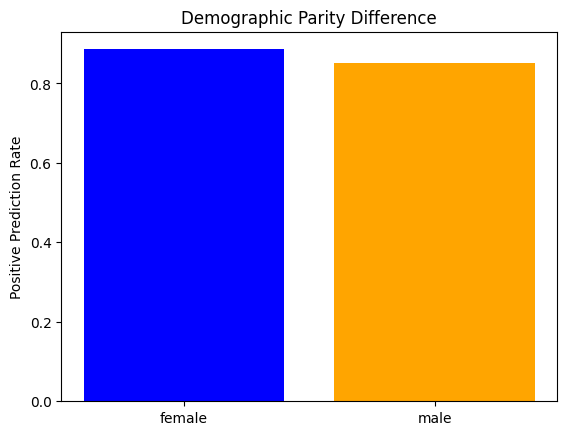

In [210]:
A_test_sex = A_test['SEX'].tolist()
rates = [sum(preds_v7[i] for i in range(len(A_test_sex)) if A_test_sex[i] == group) / A_test_sex.count(group) for group in groups]
plt.bar(groups, rates, color=['blue', 'orange'])
plt.title("Demographic Parity Difference")
plt.ylabel("Positive Prediction Rate")
plt.show()

In [211]:
# Razlike v pravilno pozitivnih deležih
trp_diff = true_positive_rate_difference(y_test, preds_v7, sensitive_features=A_test['SEX'])
print(f"True Positive Rate Difference: {trp_diff}")

True Positive Rate Difference: 0.01991689595802626


In [212]:
# Razlike v napačno pozitivnih deležih
fpr_diff = false_positive_rate_difference(y_test, preds_v7, sensitive_features=A_test['SEX'])
print(f"False Positive Rate Difference: {fpr_diff}")

False Positive Rate Difference: 0.028557605916096462


#### Senzitivna spremenljivka 'SEX_EDUCATION' 

In [213]:
classifier_v7_ = Pipeline(
    steps=[
        ('preprocessing', CustomMinMaxScaler()),
        ('classifier', FairClassifierV7(RandomForestClassifier)),
    ]
)

In [214]:
# učenje modela
classifier_v7_.fit((X_train, A_train['SEX_EDUCATION']), y_train)

Pipeline(steps=[('preprocessing', CustomMinMaxScaler()),
                ('classifier',
                 FairClassifierV7(clf_type=<class 'sklearn.ensemble._forest.RandomForestClassifier'>))])

In [215]:
# interni modeli in razredi klasifikatorja
print(classifier_v7_['classifier'].models)
print(classifier_v7_['classifier'].classes_)

{'female_edu1': RandomForestClassifier(), 'female_edu2': RandomForestClassifier(), 'female_edu3': RandomForestClassifier(), 'female_edu_other': RandomForestClassifier(), 'male_edu1': RandomForestClassifier(), 'male_edu2': RandomForestClassifier(), 'male_edu3': RandomForestClassifier(), 'male_edu_other': RandomForestClassifier()}
[0 1]


In [216]:
# napovedi nad testnimi podatki
preds_v7_ = classifier_v7_.predict(X_test)
print(preds_v7_, preds_v7_.shape)

[1 1 1 ... 1 1 1] (6000,)


C:\Users\dejan\AppData\Local\pypoetry\Cache\virtualenvs\magistrska-projekt-eHWh96MI-py3.12\Lib\site-packages\sklearn\pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


Evalvacija modelov:

In [217]:
# Natančnost za posamezno senzitivno skupino

groups = np.unique(A_test['SEX_EDUCATION'])
group_accuracies = []
for group in groups:
    mask = A_test['SEX_EDUCATION'] == group
    group_accuracy = accuracy_score(y_test[mask], preds_v7_[mask])
    group_accuracies.append(group_accuracy)
    print(f"Accuracy for group {group}: {group_accuracy:.2f}")

Accuracy for group female_edu1: 0.83
Accuracy for group female_edu2: 0.81
Accuracy for group female_edu3: 0.78
Accuracy for group female_edu_other: 0.91
Accuracy for group male_edu1: 0.80
Accuracy for group male_edu2: 0.78
Accuracy for group male_edu3: 0.74
Accuracy for group male_edu_other: 0.91


In [218]:
# Razlike v demografski enakosti
dp_diff = demographic_parity_difference(y_test, preds_v7_, sensitive_features=A_test['SEX_EDUCATION'])
print(f"Demographic Parity Difference: {dp_diff}")

Demographic Parity Difference: 0.07106598984771573


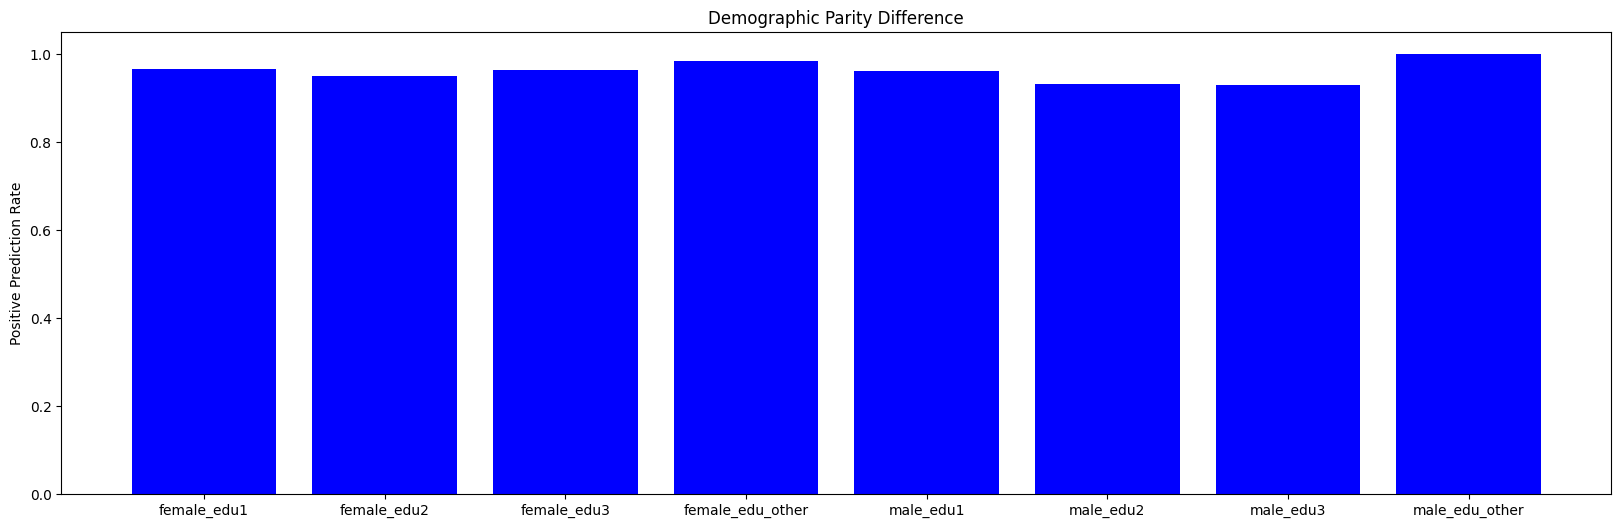

In [219]:
A_test_sexedu = A_test['SEX_EDUCATION'].tolist()
rates = [sum(preds_v7_[i] for i in range(len(A_test_sexedu)) if A_test_sexedu[i] == group) / A_test_sexedu.count(group) for group in groups]
plt.figure(figsize=(20,6))
plt.bar(groups, rates, color=['blue'])
plt.title("Demographic Parity Difference")
plt.ylabel("Positive Prediction Rate")
plt.show()

In [220]:
# Razlike v pravilno pozitivnih deležih
trp_diff = true_positive_rate_difference(y_test, preds_v7_, sensitive_features=A_test['SEX_EDUCATION'])
print(f"True Positive Rate Difference: {trp_diff}")

True Positive Rate Difference: 0.019035532994923887


In [221]:
# Razlike v napačno pozitivnih deležih
fpr_diff = false_positive_rate_difference(y_test, preds_v7_, sensitive_features=A_test['SEX_EDUCATION'])
print(f"False Positive Rate Difference: {fpr_diff}")

False Positive Rate Difference: 0.20357142857142863
